# Face-Mask-Classification Project


Authors:
+ Tobias Palmowski
+ Fabian Metz
+ Thilo Sander

Date of Midterm-Report: 29.03.2021 <br>
Date of final submission: 26.04.2021


### Introduction

This Jupyter Notebook is the core of the Face-Mask-Classification Project performed in the class "Machine Learning" of the Hertie School in Berlin. There is one other Jupyter Notebook which deals with combining the different datasets into one large data set - a task only performed once and therefore outsourced to another file.

The following code is losely based on the chapter "Classification" from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow" by Aurélien Géron.

We included several hints were we are working on in yellow warning boxes.

<br>
<br>
<br>
<br>

### Preparation

<br>
This part loads the necessary libraries and packages as well as setting the Input and Output Directories.

In [1]:
# Import necessary libraries and set-up Jupyter NoteMasked-Face-Net-Datasetbook.

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns # for plotting
import matplotlib as mpl # for plotting
import matplotlib.pyplot as plt # for plotting
import timeit # To keep track of calculation time
import PIL #Python Image Library
import pickle

# to make this notebook's output stable across runs (safety measure)
np.random.seed(42)

In [2]:
# Switch between toy and full data
full_data_switch_on = True #Set True for full data set and False for Dummy Data set (see comment below)

<div class="alert alert-block alert-danger">
<b>Action required</b>
<p>
    
You have to set the switch whether you want to use the full dataset (True) or the dummy toy dataset (False). We set aside 100 correct and 100 incorrect pictures into a dummy toy data set in order to test our code faster. For running the algorithm with the dummy toy data everything is included in the GitHub-Repository (in the folder "01_data/99_dummy_toy_data"). The corresponding .pkl-file that include the output of the first Jupyter Notebook is included in the repository as well (in the folder "01_data/01_cleaned/")
    
However, if you want to run the algorithm with the full data set, you have to download the corresponding files under the Dropbox-Link below. The raw data is placed in the Dropbox folder "00_raw" (Hint: It is ca. 40,5 GB) and you have to download it into the repository folder "01_data/00_raw/". The corresponding pickle files depending on the pixel resolution you choose (see code at bottom of Jupyter Notebook) are several GB big and are also available in the Dropbox-Folder under "01_cleaned". This file has to be placed in the corresponding repository folder "01_data/01_cleaned/" to make this code run .

The reason why we cannot directly use the links here is that we do not have figured out yet how to loop through subfolders and files Dropbox online. GitHub does not allow us to upload such an amount of data.
<br>
Dropbox-Link: https://www.dropbox.com/sh/45vbkq1ihfnhqem/AAADdq6mJKaLsG1w7SDK-QV8a?dl=0    

<br>
<b>
!!!  Be aware: Running this Jupyter Notebook with the full data set requires several hours of runtime depending on your hardware !!!

</b>    
</div>

In [3]:
# Defining path to cleaned data folder
PATH_CLEANED_DATA = "01_data/01_cleaned"

# Where to save figures
ROOT_FIGS = "02_figures"
TOPIC_ID = "02_baseline"
IMAGES_PATH = os.path.join(ROOT_FIGS, TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

CM_IMAGES_PATH = os.path.join(IMAGES_PATH, "Confusion_Matrices")
os.makedirs(CM_IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, SAVE_PATH=IMAGES_PATH, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(SAVE_PATH, fig_id + "." + fig_extension)
    print(">... Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Where to save general output (not figures)
ROOT_OUTPUT = "03_output"
TOPIC_ID = "01_eval_scores"
OUTPUT_PATH_EVAL = os.path.join(ROOT_OUTPUT, TOPIC_ID)
os.makedirs(OUTPUT_PATH_EVAL, exist_ok=True)

TOPIC_ID2 = "02_error_tables"
OUTPUT_PATH_ERROR_TABLES = os.path.join(ROOT_OUTPUT, TOPIC_ID2)
os.makedirs(OUTPUT_PATH_ERROR_TABLES, exist_ok=True)

TOPIC_ID3 = "03_run_time_scores"
OUTPUT_PATH_RUN_TIME = os.path.join(ROOT_OUTPUT, TOPIC_ID3)
os.makedirs(OUTPUT_PATH_RUN_TIME, exist_ok=True)

TOPIC_ID4 = "04_eval_scores_hypertuning"
OUTPUT_PATH_EVAL_HYPER = os.path.join(ROOT_OUTPUT, TOPIC_ID4)
os.makedirs(OUTPUT_PATH_EVAL_HYPER, exist_ok=True)

TOPIC_ID5 = "05_error_tables_hyptertuning"
OUTPUT_PATH_ERROR_TABLES_HYPER = os.path.join(ROOT_OUTPUT, TOPIC_ID5)
os.makedirs(OUTPUT_PATH_ERROR_TABLES_HYPER, exist_ok=True)

TOPIC_ID6 = "06_run_time_scores_hyptertuning"
OUTPUT_PATH_RUN_TIME_HYPER = os.path.join(ROOT_OUTPUT, TOPIC_ID6)
os.makedirs(OUTPUT_PATH_RUN_TIME_HYPER, exist_ok=True)

TOPIC_ID7 = "07_hyptertuning_best_params"
OUTPUT_PATH_BEST_PARAMS = os.path.join(ROOT_OUTPUT, TOPIC_ID7)
os.makedirs(OUTPUT_PATH_BEST_PARAMS, exist_ok=True)

TOPIC_ID8 = "08_eval_scores_dim_red"
OUTPUT_PATH_EVAL_DIM_RED = os.path.join(ROOT_OUTPUT, TOPIC_ID8)
os.makedirs(OUTPUT_PATH_EVAL_DIM_RED, exist_ok=True)

TOPIC_ID9 = "09_error_tables_dim_red"
OUTPUT_PATH_ERROR_TABLES_DIM_RED = os.path.join(ROOT_OUTPUT, TOPIC_ID9)
os.makedirs(OUTPUT_PATH_ERROR_TABLES_DIM_RED, exist_ok=True)

TOPIC_ID10 = "10_run_time_scores_dim_red"
OUTPUT_PATH_RUN_TIME_DIM_RED = os.path.join(ROOT_OUTPUT, TOPIC_ID10)
os.makedirs(OUTPUT_PATH_RUN_TIME_DIM_RED, exist_ok=True)

<br>
<br>
<br>
<br>

## Functions

<br>
This part defines all necessary functions used in the notebook

#### Test/Show available pixel resolutions

In [4]:
# Show available pixel resolutions
def show_avail_pixels():    
    # List all files in cleaned data folder
    filenames = []
    for root, dirs, files in os.walk(PATH_CLEANED_DATA):
        for name in files:
            filenames.append(os.path.join(root, name))
    
    # Separate filenames of dummy toy and full data set (and extacting available pixels)        
    pixels_dummy_toy = []
    pixels_full = []
    for i in range(len(filenames)):
        if "dummy_toy" in filenames[i]:
            # Find pixel resolution in filenames
            search_term = "dummy_toy_"
            pos_start = filenames[i].find(search_term)
            pos_end = filenames[i].find(".")
            help_length = len(search_term) #To add on starting posting
            pixel_string = filenames[i][pos_start+help_length:pos_end]
            # Append pixel resolutions to list
            pixels_dummy_toy.append(pixel_string)
        elif "full" in filenames[i]:
            # Find pixel resolution in filenames
            search_term = "full_"
            pos_start = filenames[i].find(search_term)
            pos_end = filenames[i].find(".")
            help_length = len(search_term) #To add on starting posting
            pixel_string = filenames[i][pos_start+help_length:pos_end]
            # Append pixel resolutions to list
            pixels_full.append(pixel_string)
        else:
            raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
    
    # Transforming pixel resolution strings into integers and sorting
    for itr in range(len(pixels_dummy_toy)):
        pixels_dummy_toy[itr] = int(pixels_dummy_toy[itr])
    pixels_dummy_toy.sort()
    pixels_full = [int(i) for i in pixels_full]
    pixels_full.sort()
    
    # Output depending on switch
    if full_data_switch_on == True:
        print("The following pixels are available for the full data set: ", pixels_full)
        return pixels_full
    elif full_data_switch_on == False:
        print("The following pixels are available for the dummy toy data set: ", pixels_dummy_toy)
        return pixels_dummy_toy
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")

In [5]:
# Define Check of pixel resolutions
def check_pixels(pix_res):
    avail_pixels = show_avail_pixels()
    if pix_res in avail_pixels:
        print("The specified pixel resolution {} is available!".format(pix_res))
    else:
        raise ValueError("The specified pixel resolution {} is not available! See available pixel resolutions above error message.".format(pix_res))

<br>
<br>
<br>
<br>
<br>
<br>

#### Load and split specified data set

In [6]:
# Definition of function to load corresponding pixel resolution file
def load_data(pix_res):
    # Define datafile path
    if full_data_switch_on == True:
        DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    # Load pickle file
    pic_data = pickle.load(open(DATAFILE_PATH,"rb"))
    print(">... Pickle datafile successfully loaded: ", DATAFILE_PATH)
    
    # Copying dictionary data into separate data frames
    rgb_data, labels, pic_ids = pic_data["rgb_data"], pic_data["labels"], pic_data["pic_ids"]
    print(">... Pickle dictionary sucessfully separated into individuals arrays")
    
    # Split into test and training data set
    from sklearn.model_selection import train_test_split
    rgb_data_train, rgb_data_test, labels_train, labels_test, pic_ids_train, pic_ids_test = train_test_split(rgb_data, labels, pic_ids, test_size=0.10, random_state=42)
    print(">... Data sucessfully split into test and train data")
    
    # redefining labels as True False
    labels_train_tf = (labels_train == 1)
    labels_test_tf = (labels_test == 1)
    
    return rgb_data_train, rgb_data_test, labels_train_tf, labels_test_tf, pic_ids_train, pic_ids_test
    

<br>
<br>
<br>
<br>
<br>
<br>

#### Train specified classifier on data set

In [8]:
# Definition of function that trains classifier on specified data set
def train_clasf(classifier_x, rgb_train, labels_train, pixel_res, hyper):
    
    # Defining save path depening on hyper parameter "hyper"
    if hyper == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif hyper == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
    else:
        raise ValueError("Check hyper-parameter 'hyper'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")
     
    
    #Start timer
    start_time = timeit.default_timer()
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting", classifier_name)
    
    #Train model
    classifier_x.fit(rgb_train, labels_train)
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    
    # Store run-time info
    run_time_info = {}
    run_time_info[str(pixel_res)] = round(time_elapsed, 3)
    if full_data_switch_on == True:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_train_full_"+str(classifier_name)+"_"+str(pixel_res)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_train_dummy_toy_"+str(classifier_name)+"_"+str(pixel_res)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(run_time_info, file)
    file.close()
    print("Successfully stored in: {}".format(FILE_PATH))
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,2)))

<br>
<br>
<br>
<br>
<br>
<br>

#### Evaluate specified classifier on specified data

In [9]:
# Define Evaluation function
def eval_clasf(classifier_x, rgb_data, labels, pic_ids, pix_res, hyper):
    # Import metrics and validation methods
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_confusion_matrix, precision_recall_curve
    import matplotlib.pyplot as plt 
    
    # Defining save path depening on hyper parameter "hyper"
    if hyper == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif hyper == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
    else:
        raise ValueError("Check hyper-parameter 'hyper'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")
    
    # Start timer
    start_time = timeit.default_timer()
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting evaluation of", classifier_name)
    
    # Evaluate classifier
    print(">... Starting cross validation of", classifier_name)
    pred=cross_val_predict(classifier_x, rgb_data, labels, cv = 3) # cross value prediction with 3 folds
    
    
    # Store evaluation metrics
    print(">... Saving evaluation metric of", classifier_name)
    # Running cross validation score
    cvs = cross_val_score(classifier_x, rgb_data, labels, cv=3, scoring="accuracy").round(3)
    # Initialize eval dictionary and store values
    evaluation_scores = {}
    evaluation_scores["Precision Score"] = precision_score(labels, pred).round(3)
    evaluation_scores["Recall Score"] = recall_score(labels, pred).round(3)
    evaluation_scores["Confusion matrix"] = confusion_matrix(labels, pred)
    evaluation_scores["Cross Validation Accuracy Scores"] = cvs
    evaluation_scores["Cross Validation Accuracy Score Mean"] = cvs.mean().round(3)
    evaluation_scores["Cross Validation Accuracy Score Std"] = cvs.std().round(5)
  
    
    # Data for Precision recall curve //RandomForestClassifier //DecisionTreeClassifier
    if classifier_name ==  'SGDClassifier':
        print(">... Saving precision, recalls and thresholds of", classifier_name)
        decision_scores = cross_val_predict(classifier_x, rgb_data, labels, cv = 3, method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(labels,decision_scores)
        #storing precision reacall and treshold values in eval directory
        evaluation_scores["Precisions"] = precisions
        evaluation_scores["Recalls"] = recalls
        evaluation_scores["Thresholds"] = thresholds
    elif classifier_name == 'LinearSVC':
        print(">... Saving precision, recalls and thresholds of", classifier_name)
        decision_scores = cross_val_predict(classifier_x, rgb_data, labels, cv = 3, method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(labels,decision_scores)
        #storing precision reacall and treshold values in eval directory
        evaluation_scores["Precisions"] = precisions
        evaluation_scores["Recalls"] = recalls
        evaluation_scores["Thresholds"] = thresholds
    else:
         print (">... Precision-recall-curve not applicable for this classifier")
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    evaluation_scores["Evaluation run-time in seconds"] = round(time_elapsed, 3)
    
    # Storing evaluations scores into pickle file to access them later
    if full_data_switch_on == True: 
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_" + str(classifier_name) + "_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_" + str(classifier_name) + "_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(EVAL_FILE_PATH,"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    print(">... Evaluation scores successfully stored in: {}".format(EVAL_FILE_PATH))
    
    
    # Create output array with error-types and pic ids
    # Combine pics ids, labels and predicted values
    print(">... Starting to create output array with error-types for more transparency for classifier {}.".format(classifier_name))
    output_dict = {}
    output_array = np.c_[pic_ids, labels, pred]
    
    # Create error array with specific error type
    err_type_arr = np.array([])
    for i in range(len(output_array)):
        if output_array[i,1] == "True" and output_array[i,2] == "False":
            err_type_arr = np.append(err_type_arr, "False negative")
        elif output_array[i,1] == "False" and output_array[i,2] == "True":
            err_type_arr = np.append(err_type_arr, "False positive")
        else:
            err_type_arr = np.append(err_type_arr, "No error")
    
    # Combine error into and output array into pandas data frame
    error_table_pd = pd.DataFrame(output_array)
    error_table_pd.rename(columns = {0:'Filename picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
    error_table_pd["Error Type"] = err_type_arr
    
    # Saving all in dictionary
    output_dict["error_table"] = error_table_pd
    
    # Saving dictionary of error table
    if full_data_switch_on == True: 
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_" + str(classifier_name) + "_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_" + str(classifier_name) + "_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(ERROR_TABLE_FILE_PATH,"wb")
    pickle.dump(output_dict, file)
    file.close()
    print(">... Error table dictionary successfully stored in: {}".format(ERROR_TABLE_FILE_PATH))
    
    
    # Output message
    print(">... Evaluation of classifier {} sucessfully finished in {} seconds.".format(classifier_name, round(time_elapsed,2)))


<br>
<br>
<br>
<br>
<br>
<br>

#### Define showing output functions

In [10]:
# Defining function that shows and stores all showable outputs
def show_evals(pix_res, hyper, error_table=True, conf_matrix=True, eval_metrics=True):

    # Defining save path depening on hyper parameter "hyper"
    if hyper == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif hyper == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
    else:
        raise ValueError("Check hyper-parameter 'hyper'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")
    
    
    
    ###### Error Table ######
    if error_table == True:
        # List all files of error table folder
        filenames_error_table = []
        for root, dirs, files in os.walk(SAVE_PATH_ERROR_TABLE):
            for name in files:
                filenames_error_table.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_error_table_pix = []
        for i in range(len(filenames_error_table)):
            if str(pix_res) in filenames_error_table[i]:
                filenames_error_table_pix.append(filenames_error_table[i])
        
        # Display error table
        for i in range(len(filenames_error_table_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_error_table_pix[i]:
                # Find pixel resolution in filenames
                search_term = "error_table_pd_"
                pos_start = filenames_error_table_pix[i].find(search_term)
                pos_end = filenames_error_table_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_error_table_pix[i]:
                # Find pixel resolution in filenames
                search_term = "error_table_pd_"
                pos_start = filenames_error_table_pix[i].find(search_term)
                pos_end = filenames_error_table_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
            
            # Load pickle-file and display pandas data frame filtered to error types
            dict_error_table = pickle.load(open(filenames_error_table_pix[i],"rb"))
            print(">... Error table pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            error_table_pd = dict_error_table["error_table"]
            filter_options = ["False positive", "False negative"]
            print(">... Print error table for pixel resolution {} of {}\n\n".format(pix_res, classifier_name))
            print(error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"]))
            print("\n\n")
    
    elif error_table == False:
        print("Error Table for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'error_table': Has to be binary True or False")

        
    ###### Confusion Matrix ######
    if conf_matrix == True:
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(SAVE_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(pix_res) in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])
        
        # Display confusion matrix
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
        
            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract confusion matrix data into data frame
            cm_data = dict_eval_metrics["Confusion matrix"]
            plot_matrix = pd.DataFrame(cm_data, columns = ["classified as no mask", "classified as mask"],
                                index = ["no mask", "mask"])
            
            # Actual plot with seaborn and saving figure with different file names depending on switch
            print(">... Displaying confusion matrix for {} and pixel resolution {}".format(classifier_name, pix_res))
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                plt.figure(figsize = (5,5))
                colormap = sns.color_palette("Reds")
                ax = plt.axes()
                sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
                ax.set_title(classifier_name, fontsize= 15)
                plt.show()
                save_fig("99_CM_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
            elif "full" in filenames_eval_dics_pix[i]:
                plt.figure(figsize = (5,5))
                colormap = sns.color_palette("Reds")
                ax = plt.axes()
                sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
                ax.set_title(classifier_name, fontsize= 15)
                plt.show()
                save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
                
    elif conf_matrix == False:
        print("Confusion matrix for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'conf_matrix': Has to be binary True or False")           
    
    
   
   

    ###### Eval Metrics ######
    if eval_metrics == True:
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(SAVE_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(pix_res) in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])
                
        eval_metrics = {}
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
            
            
            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract eval metrics into data frame
            precision_score = dict_eval_metrics["Precision Score"]
            recall_score = dict_eval_metrics["Recall Score"]
            cv_acc_scores = dict_eval_metrics["Cross Validation Accuracy Scores"]
            cv_acc_scores_mean = dict_eval_metrics["Cross Validation Accuracy Score Mean"]
            cv_acc_scores_std = dict_eval_metrics["Cross Validation Accuracy Score Std"]
            eval_run_time = dict_eval_metrics["Evaluation run-time in seconds"]
            
            #Storing in eval_metrics library
            eval_metrics[classifier_name] = [precision_score,
                                             recall_score,
                                             cv_acc_scores,
                                             cv_acc_scores_mean,
                                             cv_acc_scores_std,
                                             eval_run_time]
        
        # Output table of metrics
        print(">... Display eval metrics table for pixel resolution {}\n\n".format(pix_res))
        index = ["precision score", "recall score", "cross validation scores", "cross validation mean", "cross validation std", "eval run time in seconds"]
        table_eval_metrics = pd.DataFrame(eval_metrics, index)
        print(table_eval_metrics, "\n\n")  
    
    elif eval_metrics == False:
        print("Eval metrics for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'eval_metrics': Has to be binary True or False")      

        
        

In [11]:
# define function Precision Recall Plots
def show_PR_curves(pix_res, classifier_x, hyper):

    # Defining save path depening on hyper parameter "hyper"
    if hyper == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif hyper == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
    else:
        raise ValueError("Check hyper-parameter 'hyper'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")

    if str(classifier_x)[:str(classifier_x).find("(")] == 'SGDClassifier' or str(classifier_x)[:str(classifier_x).find("(")] == 'LinearSVC':
        ###### Precision-Recall Plots #####     
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(SAVE_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))

        #Select all filenames corresponding to pixel size and specified classifiers
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(classifier_x)[:str(classifier_x).find("(")] in filenames_eval_dics[i] and str(pix_res) in filenames_eval_dics[i] and "evaluation_scores" in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])

        print(filenames_eval_dics_pix)

        eval_metrics = {}
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract eval metrics into data frame
            print(">... Extracting Metrics into Dataframe of classifier"+str(classifier_x))
            precisions = dict_eval_metrics["Precisions"]
            recalls = dict_eval_metrics["Recalls"]
            thresholds = dict_eval_metrics["Thresholds"]

            # Plot and saving figure with different file names depending on switch
            print(">... Displaying Precision-Recall Plot for {} and pixel resolution {}".format(classifier_name, pix_res))
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                plt.figure(figsize=(8,4))
                plt.plot(thresholds, precisions[:-1],"b--",label = "Precision", linewidth=2)
                plt.plot(thresholds, recalls[:-1], "g--",label = "Recall", linewidth=2)
                plt.xlabel("Threshold", fontsize = 16)
                plt.legend(loc="lower left", fontsize = 16)
                plt.ylim([0,1])
                plt.show()
                #save_fig("99_PRP_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=PRP_IMAGES_PATH)
            elif "full" in filenames_eval_dics_pix[i]:
                plt.figure(figsize=(8,4))
                plt.plot(thresholds, precisions[:-1],"b--",label = "Precision", linewidth=2)
                plt.plot(thresholds, recalls[:-1], "g--",label = "Recall", linewidth=2)
                plt.xlabel("Threshold", fontsize = 16)
                plt.legend(loc="lower left", fontsize = 16)
                
                plt.ylim([0,1])
                plt.show()
                #save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=PRP_IMAGES_PATH)
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
        

      
        

<div class="alert alert-block alert-warning">
<b>TO DO</b>
<p>
    
+ Saving of plots doesn't work properly yet. It saves a figure, but with no content.
+ Displaying tables could be cooler and especially saving them would be great
</div>

<div class="alert alert-block alert-warning">
<b>ATTENTION</b>
<p>
Furhter sources for plotting things for precision and recall curves etc
</div>

 Use plot sklearn.metrics below more heavily: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics --->Plotting
 
 ---> Visualizations: https://scikit-learn.org/stable/visualizations.html#visualizations
 
 metrics.plot_confusion_matrix(estimator, X, …)
	

Plot Confusion Matrix.

metrics.plot_det_curve(estimator, X, y, *[, …])
	

Plot detection error tradeoff (DET) curve.

metrics.plot_precision_recall_curve(…[, …])
	

Plot Precision Recall Curve for binary classifiers.

metrics.plot_roc_curve(estimator, X, y, *[, …])
	

Plot Receiver operating characteristic (ROC) curve.


metrics.ConfusionMatrixDisplay(…[, …])
	

Confusion Matrix visualization.

metrics.DetCurveDisplay(*, fpr, fnr[, …])
	

DET curve visualization.

metrics.PrecisionRecallDisplay(precision, …)
	

Precision Recall visualization.

metrics.RocCurveDisplay(*, fpr, tpr[, …])
	

ROC Curve visualization.




<br>
<br>
<br>
<br>
<br>
<br>

#### Define pipeline functions for evaluation and showing

In [12]:
# Defining pipeline function for load, training, evaluating of baseline

def load_train_eval(list_of_pixels, list_of_classifiers, hyper=False):
    for pix in list_of_pixels:
        print("\n\n\n>... Starting load_train_eval process for pixel resolution: {}.".format(pix))
        # Start timer pixel resolution
        start_time_pix = timeit.default_timer()
        # Test pixels
        check_pixels(pix)
        # Load
        rgb_data_train, rgb_data_test, labels_train, labels_test, pic_ids_train, pic_ids_test = load_data(pix)

        # Run the different classifiers
        for clasf in list_of_classifiers:
            # Train
            # train_clasf(clasf, rgb_data_train, labels_train, pix, hyper)
            # Evaluate
            eval_clasf(clasf, rgb_data_train, labels_train, pic_ids_train, pix, hyper)

        #End timer and output message
        elapsed_pix = timeit.default_timer() - start_time_pix
        print("\n>... Ending load_train_eval process for pixel resolution: {}. Run-time: {} seconds.".format(pix, round(elapsed_pix,2)))

# Defining pipeline function for showing evaluations
def show_evals_pipeline(list_of_pixels, list_of_classifiers, hyper, error_table_switch=False, conf_matrix_switch=False, eval_metrics_switch=False, prec_recall_plot_switch =False):
    for pix in list_of_pixels:
        print("\n\n\n>... Start showing evals for pixel resolution: {}.".format(pix))
        # Start timer pixel resolution
        start_time_pix = timeit.default_timer()
        
        # Show evals
        show_evals(pix, hyper, error_table=error_table_switch, conf_matrix=conf_matrix_switch, eval_metrics=eval_metrics_switch)
        
        # Show Precision Recall Curves
        for clasf in list_of_classifiers:
            show_PR_curves(pix, clasf, hyper)
        
        #End timer and output message
        elapsed_pix = timeit.default_timer() - start_time_pix
        print("\n>... Ending showing evals for pixel resolution: {}. Run-time: {} seconds.".format(pix, round(elapsed_pix,2)))


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### Calling functions for Baseline

In [13]:
# Show available pixel resolutions
show_avail_pixels()

The following pixels are available for the full data set:  [16, 24, 32]


[16, 24, 32]

<div class="alert alert-block alert-danger">
<b>Action required</b>
<p>
    
Here you have to specify the pixel resolution with which you want to run the evaluations. Also be aware of the switch between full and dummy toy data set in the beginning of the jupyter notebook!
<br>
If you want to run the algorithm with the full data set, you have to download the corresponding pickle files (several GB) from the Dropbox-Folder under "01_cleaned". This file has to be placed in the corresponding repository folder to make this code run "01_data/01_cleaned/".
<br>
Dropbox-Link: https://www.dropbox.com/sh/45vbkq1ihfnhqem/AAADdq6mJKaLsG1w7SDK-QV8a?dl=0    

<br>
<b>
!!!  Be aware: Running the this Jupyter Notebook with the full data set requires several hours of runtime depending on your hardware !!!

</b>    
</div>

In [13]:
# Also be aware of switch between full and toy data set in the beginning of the jupyter notebook!



####### Pixels #######
# Specify pixel resolutions
pixels = [24] #[16, 24, 32] 



####### Classifiers #######
# import and define classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
# from sklearn.neighbors import KNeighborsClassifier # KNN had several hours runtime and kernel always died before finising
from sklearn.linear_model import SGDClassifier#, LogisticRegression # LogReg hat several hours runtime and kernel always died before finishing
classifier_RandomForest = RandomForestClassifier(random_state=42)
classifier_DecTree = tree.DecisionTreeClassifier(random_state=42)
classifier_LinSVC = svm.LinearSVC(max_iter=4000, tol=1e-3, random_state=42) #linear as normal (c based) is impractical using large datasets
classifier_SGD = SGDClassifier(random_state=42)
# classifier_KNN = KNeighborsClassifier(n_neighbors=1)
# classifier_LogReg = LogisticRegression(max_iter=2000, tol=1e-3,random_state=42)


# Combine classifiers to a list through which you can loop
classifiers= [classifier_RandomForest, classifier_DecTree, classifier_LinSVC, classifier_SGD]



####### Actual running #######
load_train_eval(pixels, classifiers)
print("\n\n\n\n\n\n\n\n","##### BREAK #####","\n\n\n\n\n\n\n\n")
# show_evals_pipeline(pixels, classifiers, error_table_switch=False, conf_matrix_switch=False, eval_metrics_switch=False, prec_recall_plot_switch =False )






>... Starting load_train_eval process for pixel resolution: 24.
The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays
>... Data sucessfully split into test and train data
>... Starting RandomForestClassifier
Successfully stored in: 03_output/01_eval_scores/run_time_train_full_RandomForestClassifier_24.pkl
>... Classifier RandomForestClassifier sucessfully trained in 394.27 seconds.
>... Starting evaluation of RandomForestClassifier
>... Starting cross validation of RandomForestClassifier
>... Saving evaluation metric of RandomForestClassifier
>... Precision-recall-curve not applicable for this classifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_RandomForestClassifier_full_24.pkl
>... Starting to create output array with 

/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Successfully stored in: 03_output/01_eval_scores/run_time_train_full_LinearSVC_24.pkl
>... Classifier LinearSVC sucessfully trained in 1348.13 seconds.
>... Starting evaluation of LinearSVC
>... Starting cross validation of LinearSVC


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Saving evaluation metric of LinearSVC


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Saving precision, recalls and thresholds of LinearSVC


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_LinearSVC_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier LinearSVC.
>... Error table dictionary successfully stored in: 03_output/02_error_tables/error_table_pd_LinearSVC_full_24.pkl
>... Evaluation of classifier LinearSVC sucessfully finished in 6807.78 seconds.
>... Starting SGDClassifier
Successfully stored in: 03_output/01_eval_scores/run_time_train_full_SGDClassifier_24.pkl
>... Classifier SGDClassifier sucessfully trained in 66.64 seconds.
>... Starting evaluation of SGDClassifier
>... Starting cross validation of SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Saving precision, recalls and thresholds of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_SGDClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifi




>... Start showing evals for pixel resolution: 24.
Error Table for pixel resolution 24 not selected by user.
>... Eval metrics pickle file successfully loaded for LinearSVC and pixel resolution 24
>... Displaying confusion matrix for LinearSVC and pixel resolution 24


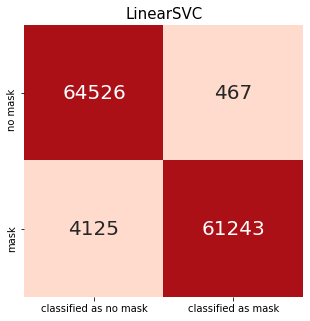

>... Saving figure Confusion_Matrix_LinearSVC_24
>... Eval metrics pickle file successfully loaded for RandomForestClassifier and pixel resolution 24
>... Displaying confusion matrix for RandomForestClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

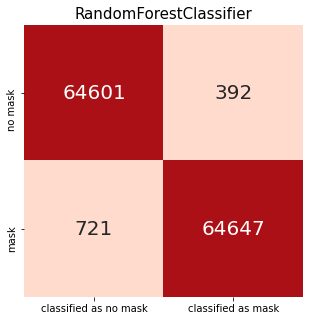

>... Saving figure Confusion_Matrix_RandomForestClassifier_24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for SGDClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

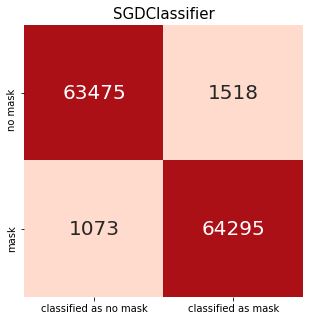

>... Saving figure Confusion_Matrix_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for DecisionTreeClassifier and pixel resolution 24
>... Displaying confusion matrix for DecisionTreeClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

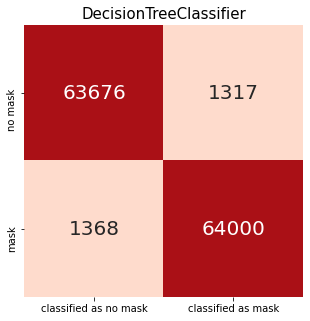

>... Saving figure Confusion_Matrix_DecisionTreeClassifier_24
>... Eval metrics pickle file successfully loaded for LinearSVC and pixel resolution 24
>... Eval metrics pickle file successfully loaded for RandomForestClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for DecisionTreeClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24


                                      LinearSVC RandomForestClassifier  \
precision score                           0.992                  0.994   
recall score                              0.937                  0.989   
cross validation scores   [0.971, 0.966, 0.957]  [0.992, 0.991, 0.992]   
cross validation mean                     0.965                  0.992   
cross validation std                    0.00579                0.00047   
eval run time in seconds                6807.78       

<Figure size 432x288 with 0 Axes>

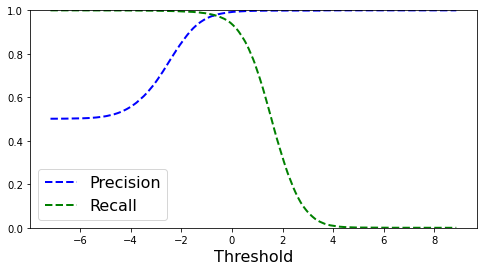

['03_output/01_eval_scores/evaluation_scores_SGDClassifier_full_24.pkl']
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Extracting Metrics into Dataframe of classifierSGDClassifier(random_state=42)
>... Displaying Precision-Recall Plot for SGDClassifier and pixel resolution 24


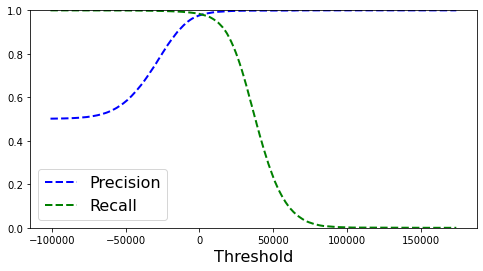


>... Ending showing evals for pixel resolution: 24. Run-time: 0.88 seconds.


In [56]:
show_evals_pipeline(pixels, classifiers, hyper=False, error_table_switch=False, conf_matrix_switch=True, eval_metrics_switch=True, prec_recall_plot_switch=False)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Accuracy improvements (Hyper-parameter tuning, voting classifier, bagging classifier)

<br>
<br>
<br>
<br>
<br>

### Hyper-parameter tuning for each classifier individually

In [17]:
# Define function that perform grid search

def hyper_tune_grid_search(classifier_x, param_grid, pixel_res, hyper=True):
    # Imporint necessary libraries
    from sklearn.model_selection import GridSearchCV
    
    
    print("\n\n\n>... Starting Grid Search for pixel resolution: {}.".format(pixel_res))
    # Start timer pixel resolution
    start_time_pix_GSCV = timeit.default_timer()
    # Test pixels
    check_pixels(pixel_res)
    # Load
    rgb_data_train, rgb_data_test, labels_train, labels_test, pic_ids_train, pic_ids_test = load_data(pixel_res)
    
    # Perform Grid-Search
    grid_search = GridSearchCV(classifier_x, param_grid, cv=3,
                            scoring=["precision", "recall", "accuracy"],
                            refit = "precision",
                            n_jobs = 4,
                            verbose = 3,
                            return_train_score = True)
    
    grid_search.fit(rgb_data_train, labels_train)
    

    #End timer
    elapsed_pix_GSCV = timeit.default_timer() - start_time_pix_GSCV
    
    # Saving Run-Time for GridSearch
    run_time_info_GSCV = {}
    run_time_info_GSCV[str(pixel_res)] = round(elapsed_pix_GSCV, 2)
    if full_data_switch_on == True:
        FILE_PATH = os.path.join(OUTPUT_PATH_RUN_TIME_HYPER + "/run_time_grid_search_full_"+str(classifier_x.__class__.__name__)+"_"+str(pixel_res)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(OUTPUT_PATH_RUN_TIME_HYPER + "/run_time_grid_search_dummy_toy_"+str(classifier_x.__class__.__name__)+"_"+str(pixel_res)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(run_time_info_GSCV, file)
    file.close()
    print(">... Successfully stored in: {}".format(FILE_PATH))
    print("\n>... Ending Grid Search process for classifier {} of pixel resolution: {}. Run-time: {} seconds.".format(classifier_x, pixel_res, round(elapsed_pix_GSCV,2)))

        
    # Extract, print and save best parameters
    print("\n>... Printing best parameters for classifer {} and pixel resolution {}\n".format(classifier_x, pixel_res))
    print(grid_search.best_params_)
    best_params_dict = {}
    best_params_dict["Grid_Search_Best_Params"] = grid_search.best_params_

    if full_data_switch_on == True:
        FILE_PATH = os.path.join(OUTPUT_PATH_BEST_PARAMS + "/best_params_grid_search_full_"+str(classifier_x.__class__.__name__)+"_"+str(pixel_res)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(OUTPUT_PATH_BEST_PARAMS + "/best_params_grid_search_dummy_toy_"+str(classifier_x.__class__.__name__)+"_"+str(pixel_res)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(best_params_dict, file)
    file.close()
    print(">... Successfully stored best hyper parameters in: {}".format(FILE_PATH))
  
    
    # Extract, print best precision score
    print("\n>... Printing best precision score for classifer {} and pixel resolution {}\n".format(classifier_x, pixel_res))
    print(grid_search.best_score_)

In [15]:
# Importing all classifiers again (for running only hyper-parameter tuning)
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.linear_model import SGDClassifier

In [15]:
# SGD
param_grid_SGD = [
    {"penalty": ["l1", "l2"],
     "alpha": [1e-4, 1e-2, 1],
     "max_iter": [100, 1000, 10000]}    
]

classifier_SGD_hyper = SGDClassifier(random_state=42)
pix = 24

hyper_tune_grid_search(classifier_x=classifier_SGD_hyper, param_grid=param_grid_SGD, pixel_res=pix, hyper=True)




>... Starting Grid Search for pixel resolution: 24.
The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays
>... Data sucessfully split into test and train data
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 80.7min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed: 468.3min finished


>... Successfully stored in: 03_output/06_run_time_scores_hyptertuning/run_time_grid_search_full_SGDClassifier_24.pkl

>... Ending Grid Search process for classifier SGDClassifier(random_state=42) of pixel resolution: 24. Run-time: 28134.76 seconds.

>... Printing best parameters for classifer SGDClassifier(random_state=42) and pixel resolution 24

{'alpha': 0.01, 'max_iter': 100, 'penalty': 'l2'}
>... Successfully stored best hyper parameters in: 03_output/07_hyptertuning_best_params/best_params_grid_search_full_SGDClassifier_24.pkl

>... Printing best precision score for classifer SGDClassifier(random_state=42) and pixel resolution 24

0.9909983109785602


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [16]:
best_params_test = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_SGDClassifier_24.pkl","rb"))

best_params_test

{'Grid_Search_Best_Params': {'alpha': 0.01, 'max_iter': 100, 'penalty': 'l2'}}

In [18]:
# Random Forest Classifier
param_grid_RandomForest = [
    {"n_estimators": [10, 100, 250],
     "max_features": ["auto", "log2", None],
     "bootstrap": [True, False]}    
]

classifier_RandomForest_hyper = RandomForestClassifier(random_state=42)
pix = 24

hyper_tune_grid_search(classifier_x=classifier_RandomForest_hyper, param_grid=param_grid_RandomForest, pixel_res=pix, hyper=True)




>... Starting Grid Search for pixel resolution: 24.
The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays
>... Data sucessfully split into test and train data
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 338.1min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed: 2141.8min finished


>... Successfully stored in: 03_output/06_run_time_scores_hyptertuning/run_time_grid_search_full_RandomForestClassifier_24.pkl

>... Ending Grid Search process for classifier RandomForestClassifier(random_state=42) of pixel resolution: 24. Run-time: 129911.96 seconds.

>... Printing best parameters for classifer RandomForestClassifier(random_state=42) and pixel resolution 24

{'bootstrap': False, 'max_features': 'auto', 'n_estimators': 250}
>... Successfully stored best hyper parameters in: 03_output/07_hyptertuning_best_params/best_params_grid_search_full_RandomForestClassifier_24.pkl

>... Printing best precision score for classifer RandomForestClassifier(random_state=42) and pixel resolution 24

0.9944737876474538


In [19]:
best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_RandomForestClassifier_24.pkl","rb"))
best_params_output

{'Grid_Search_Best_Params': {'bootstrap': False,
  'max_features': 'auto',
  'n_estimators': 250}}









 ##### BREAK ##### 











>... Start showing evals for pixel resolution: 24.
Error Table for pixel resolution 24 not selected by user.
>... Eval metrics pickle file successfully loaded for RandomForestClassifier and pixel resolution 24
>... Displaying confusion matrix for RandomForestClassifier and pixel resolution 24


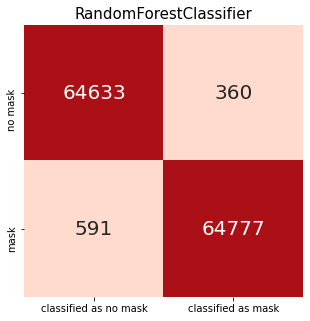

>... Saving figure Confusion_Matrix_RandomForestClassifier_24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for SGDClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

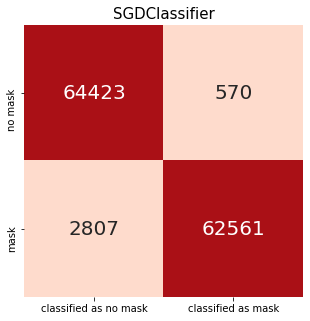

>... Saving figure Confusion_Matrix_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for RandomForestClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24


                         RandomForestClassifier          SGDClassifier
precision score                           0.994                  0.991
recall score                              0.991                  0.957
cross validation scores   [0.993, 0.992, 0.993]  [0.971, 0.972, 0.979]
cross validation mean                     0.993                  0.974
cross validation std                    0.00047                0.00356
eval run time in seconds                5271.53                  199.6 


['03_output/04_eval_scores_hypertuning/evaluation_scores_SGDClassifier_full_24.pkl']
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Extracting Met

<Figure size 432x288 with 0 Axes>

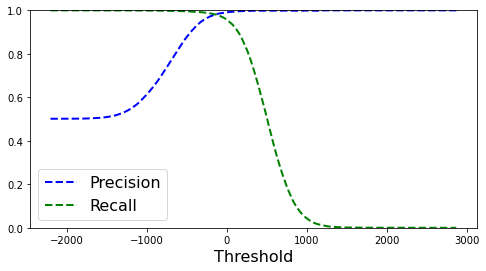


>... Ending showing evals for pixel resolution: 24. Run-time: 0.51 seconds.


In [26]:
# Evaluating both tuned classifers on training set

### Defining classifiers ###
# Random Forest
classifier_RandomForest_best_tuned = RandomForestClassifier(random_state=42,
                                                           n_estimators=250,
                                                           max_features="auto",
                                                           bootstrap=False)

# SGD
classifier_SGD_best_tuned = SGDClassifier(random_state=42,
                                         penalty="l2",
                                         alpha=0.01,
                                         max_iter=100)

# Combine classifiers to a list through which you can loop
classifiers= [classifier_RandomForest_best_tuned, classifier_SGD_best_tuned]
pixels = [24]


### Actual running ###
# load_train_eval(pixels, classifiers, hyper=True)
print("\n\n\n\n\n\n\n\n","##### BREAK #####","\n\n\n\n\n\n\n\n")
show_evals_pipeline(pixels, classifiers, hyper=True, error_table_switch=False, conf_matrix_switch=True, eval_metrics_switch=True, prec_recall_plot_switch=False)



<br>
<br>
<br>
<br>
<br>

### Voting Classifier of Random Forest and SGD Classifier

In principal voting classifiers can improve the accuracy, by combining several weaker classifiers with a voting scheme. However, as both classifiers are both performing very well already and a voting classifier would only need more time than the individual classifiers, we are not further investigating this part.

In [18]:
# Output best_params again

#best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_RandomForestClassifier_24.pkl","rb"))
#print("RandomForest: ",best_params_output)

best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_SGDClassifier_24.pkl","rb"))
print("SGD: ",best_params_output)


SGD:  {'Grid_Search_Best_Params': {'alpha': 0.01, 'max_iter': 100, 'penalty': 'l2'}}


In [ ]:
# Implementing Voting Classifier
# Importing necessary libraries
from sklearn.ensemble import VotingClassifier

### Defining classifiers ###

# Set hyper-parameters to best tuned classifiers

# Random Forest
classifier_RandomForest_voting = RandomForestClassifier(random_state=42,
                                                           n_estimators=250,
                                                           max_features="auto",
                                                           bootstrap=False)

# SGD
classifier_SGD_voting = SGDClassifier(random_state=42,
                                         penalty="l2",
                                         alpha=0.0001,
                                         max_iter=1000) #Left on 1000 because more iterations don't hurt accuracy


# Combine classifiers to a voting classifier
voting_clasf=VotingClassifier(
    estimators=[classifier_RandomForest_voting, classifier_SGD_voting],
    voting='soft')

classifiers= [voting_clasf]
pixels = [24]


### Actual running ###
load_train_eval(pixels, classifiers, hyper=True)
print("\n\n\n\n\n\n\n\n","##### BREAK #####","\n\n\n\n\n\n\n\n")
show_evals_pipeline(pixels, classifiers, hyper=True, error_table_switch=False, conf_matrix_switch=True, eval_metrics_switch=True, prec_recall_plot_switch=False)





<br>
<br>
<br>
<br>
<br>

### Bagging Classifer of SGD Classifer

tbd

In [19]:
# Output best_params again

#best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_RandomForestClassifier_24.pkl","rb"))
#print("RandomForest: ",best_params_output)

best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_SGDClassifier_24.pkl","rb"))
print("SGD: ",best_params_output)


SGD:  {'Grid_Search_Best_Params': {'alpha': 0.01, 'max_iter': 100, 'penalty': 'l2'}}


In [ ]:
# Bagging Classifier

# Import Libraries
from sklearn.ensemble import BaggingClassifier

# SGD
classifier_SGD_voting = SGDClassifier(random_state=42,
                                         penalty="l2",
                                         alpha=0.01,
                                         max_iter=1000) #Left on 1000 because more iterations don't hurt accuracy

bag_clf = BaggingClassifier(
    classifier_SGD_voting, n_estimators=500, max_samples=50, bootstrap=True, n_jobs=4, oob_score=True
)

classifiers= [bag_clf]
pixels = [24]


### Actual running ###
load_train_eval(pixels, classifiers, hyper=True)
print("\n\n\n\n\n\n\n\n","##### BREAK #####","\n\n\n\n\n\n\n\n")
show_evals_pipeline(pixels, classifiers, hyper=True, error_table_switch=False, conf_matrix_switch=True, eval_metrics_switch=True, prec_recall_plot_switch=False)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Speed improvements (dimensionality reduction)

<br>
<br>
<br>
<br>
<br>

### Plotting feature importance

Frist step of dimensionality reduction is get an understanding of the feature importance (i.e. the importance of every pixel). The code below implements the feature importance for the Random Forest Classifier.

In [29]:
# Run classifiers again, if not still saved

### Defining classifiers ###
# Importing all classifiers again (for running only hyper-parameter tuning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# Random Forest
classifier_RandomForest_best_tuned = RandomForestClassifier(random_state=42,
                                                           n_estimators=250,
                                                           max_features="auto",
                                                           bootstrap=False)

# Set Pixel resolution
pix = 24

In [33]:
# Actual running of loading and training data
print("\n\n\n>... Starting Loading and training process for pixel resolution: {}.".format(pix))
# Test pixels
check_pixels(pix)
# Load
rgb_data_train, rgb_data_test, labels_train, labels_test, pic_ids_train, pic_ids_test = load_data(pix)

# Train
classifier_RandomForest_best_tuned.fit(rgb_data_train, labels_train)
print(">... {} successfully trained.".format(classifier_RandomForest_best_tuned.__class__.__name__))
#Output message
print("\n>... Ending loading and training process for pixel resolution: {}.".format(pix))




>... Starting Loading and training process for pixel resolution: 24.
The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays
>... Data sucessfully split into test and train data
>... RandomForestClassifier successfully trained.

>... Ending loading and training process for pixel resolution: 24.


In [34]:
# Defining the function to plot the digits of feature importance
# Adapted from Aurelien Geron:
def plot_digit(data):
    image = data.reshape(pix, pix)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [35]:
# Adding feature importances from 3 RGB values to one pixel
feature_imp_sum = np.empty([(int(len(classifier_RandomForest_best_tuned.feature_importances_)/3)),])

for itr in range(int(len(classifier_RandomForest_best_tuned.feature_importances_)/3)):
    r = int(itr*3)
    g = int(r+1)
    b = int(g+1)
    feature_imp_sum[itr] = classifier_RandomForest_best_tuned.feature_importances_[r] + classifier_RandomForest_best_tuned.feature_importances_[g] + classifier_RandomForest_best_tuned.feature_importances_[b]

>... Saving figure RandomForest_feature_importance_plot


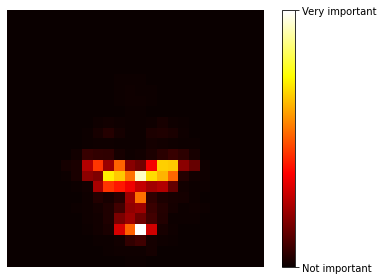

In [40]:
# Plotting feature importance sum for every pixel to a plot and save it
plot_digit(feature_imp_sum)

cbar = plt.colorbar(ticks=[feature_imp_sum.min(), feature_imp_sum.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("RandomForest_feature_importance_plot")
plt.show()

As can be seen from the plot above only a small number of pixels (i.e. features) are taken into account during the classification. Thus a dimensionality reduction will be highly beneficial in terms of run-time.

<br>
<br>
<br>
<br>
<br>

### Principal Component Analysis (PCA)

This part implements within severel of steps a Principal Component Analysis in order to reduce the dimensionality of the data set to improve the processing speed.

In [41]:
# Loading data set again and split into test and training set.
pix_res = 24
# Checking pixel resolution
check_pixels(pix)


### Loading full data-set without splitting into test and train ###
# Define datafile path
if full_data_switch_on == True:
    DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_full_" + str(pix_res) + ".pkl")
elif full_data_switch_on == False:
    DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_dummy_toy_" + str(pix_res) + ".pkl")
else:
    raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")

# Load pickle file
pic_data = pickle.load(open(DATAFILE_PATH,"rb"))
print(">... Pickle datafile successfully loaded: ", DATAFILE_PATH)

# Copying dictionary data into separate data frames
rgb_data, labels, pic_ids = pic_data["rgb_data"], pic_data["labels"], pic_data["pic_ids"]
print(">... Pickle dictionary sucessfully separated into individuals arrays")

The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays


In [42]:
from sklearn.decomposition import PCA

# Defining how much variance you want to have explained:
threshold = 0.95

pca = PCA()
pca.fit(rgb_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= threshold) + 1

In [43]:
# Showing number of features necessary to reach 95% variance explained
print("Features necessary to explain {}% variance: {}".format(threshold*100, d))

Features necessary to explain 95.0% variance: 184


>... Saving figure explained_variance_plot


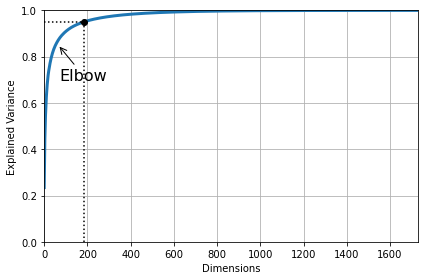

In [44]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, rgb_data.shape[1], 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:")
plt.plot([0, d], [threshold, threshold], "k:")
plt.plot(d, threshold, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

As you can see by the plot above a lot of dimensions are unnecessary for the purpose of variance explanation. Thus we can reduce the dimensionality heavily and still have a rather high accuracy.

In [45]:
# Finally: Reducing the original data set
pca = PCA(n_components=threshold)
rgb_data_reduced = pca.fit_transform(rgb_data)

<br>
<br>
<br>
<br>
<br>

### Training classifiers on new test set

In [46]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
rgb_data_train, rgb_data_test, rgb_data_reduced_train, rgb_data_reduced_test, labels_train, labels_test, pic_ids_train, pic_ids_test = train_test_split(rgb_data, rgb_data_reduced, labels, pic_ids, test_size=0.10, random_state=42)
print(">... Data sucessfully split into test and train data")

# redefining labels as True False
labels_train_tf = (labels_train == 1)
labels_test_tf = (labels_test == 1)

>... Data sucessfully split into test and train data


In [47]:
# Definition of function that trains classifier on specified data set (adopted)
def train_clasf_dim_red(classifier_x, rgb_train, labels_train, pixel_res, dim_red):
    
    # Defining save path depening on hyper parameter "hyper"
    if dim_red == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif dim_red == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_DIM_RED
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_DIM_RED
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_DIM_RED
    else:
        raise ValueError("Check hyper-parameter 'dim_red'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")
     
    
    #Start timer
    start_time = timeit.default_timer()
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting", classifier_name)
    
    #Train model
    classifier_x.fit(rgb_train, labels_train)
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    
    # Store run-time info
    run_time_info = {}
    run_time_info[str(pixel_res)] = round(time_elapsed, 3)
    if full_data_switch_on == True:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_train_full_"+str(classifier_name)+"_"+str(pixel_res)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_train_dummy_toy_"+str(classifier_name)+"_"+str(pixel_res)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(run_time_info, file)
    file.close()
    print("Successfully stored in: {}".format(FILE_PATH))
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,2)))

In [48]:
# Define Evaluation function (adopted)
def eval_clasf_dim_red(classifier_x, rgb_data, labels, pic_ids, pix_res, dim_red):
    # Import metrics and validation methods
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_confusion_matrix, precision_recall_curve
    import matplotlib.pyplot as plt 
    
    # Defining save path depening on hyper parameter "hyper"
    if dim_red == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif dim_red == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_DIM_RED
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_DIM_RED
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_DIM_RED
    else:
        raise ValueError("Check hyper-parameter 'dim_red'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")
    
    # Start timer
    start_time = timeit.default_timer()
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting evaluation of", classifier_name)
    
    # Evaluate classifier
    print(">... Starting cross validation of", classifier_name)
    pred=cross_val_predict(classifier_x, rgb_data, labels, cv = 3) # cross value prediction with 3 folds
    
    
    # Store evaluation metrics
    print(">... Saving evaluation metric of", classifier_name)
    # Running cross validation score
    cvs = cross_val_score(classifier_x, rgb_data, labels, cv=3, scoring="accuracy").round(3)
    # Initialize eval dictionary and store values
    evaluation_scores = {}
    evaluation_scores["Precision Score"] = precision_score(labels, pred).round(3)
    evaluation_scores["Recall Score"] = recall_score(labels, pred).round(3)
    evaluation_scores["Confusion matrix"] = confusion_matrix(labels, pred)
    evaluation_scores["Cross Validation Accuracy Scores"] = cvs
    evaluation_scores["Cross Validation Accuracy Score Mean"] = cvs.mean().round(3)
    evaluation_scores["Cross Validation Accuracy Score Std"] = cvs.std().round(5)
  
    
    # Data for Precision recall curve //RandomForestClassifier //DecisionTreeClassifier
    if classifier_name ==  'SGDClassifier':
        print(">... Saving precision, recalls and thresholds of", classifier_name)
        decision_scores = cross_val_predict(classifier_x, rgb_data, labels, cv = 3, method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(labels,decision_scores)
        #storing precision reacall and treshold values in eval directory
        evaluation_scores["Precisions"] = precisions
        evaluation_scores["Recalls"] = recalls
        evaluation_scores["Thresholds"] = thresholds
    elif classifier_name == 'LinearSVC':
        print(">... Saving precision, recalls and thresholds of", classifier_name)
        decision_scores = cross_val_predict(classifier_x, rgb_data, labels, cv = 3, method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(labels,decision_scores)
        #storing precision reacall and treshold values in eval directory
        evaluation_scores["Precisions"] = precisions
        evaluation_scores["Recalls"] = recalls
        evaluation_scores["Thresholds"] = thresholds
    else:
         print (">... Precision-recall-curve not applicable for this classifier")
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    evaluation_scores["Evaluation run-time in seconds"] = round(time_elapsed, 3)
    
    # Storing evaluations scores into pickle file to access them later
    if full_data_switch_on == True: 
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_" + str(classifier_name) + "_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_" + str(classifier_name) + "_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(EVAL_FILE_PATH,"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    print(">... Evaluation scores successfully stored in: {}".format(EVAL_FILE_PATH))
    
    
    # Create output array with error-types and pic ids
    # Combine pics ids, labels and predicted values
    print(">... Starting to create output array with error-types for more transparency for classifier {}.".format(classifier_name))
    output_dict = {}
    output_array = np.c_[pic_ids, labels, pred]
    
    # Create error array with specific error type
    err_type_arr = np.array([])
    for i in range(len(output_array)):
        if output_array[i,1] == "True" and output_array[i,2] == "False":
            err_type_arr = np.append(err_type_arr, "False negative")
        elif output_array[i,1] == "False" and output_array[i,2] == "True":
            err_type_arr = np.append(err_type_arr, "False positive")
        else:
            err_type_arr = np.append(err_type_arr, "No error")
    
    # Combine error into and output array into pandas data frame
    error_table_pd = pd.DataFrame(output_array)
    error_table_pd.rename(columns = {0:'Filename picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
    error_table_pd["Error Type"] = err_type_arr
    
    # Saving all in dictionary
    output_dict["error_table"] = error_table_pd
    
    # Saving dictionary of error table
    if full_data_switch_on == True: 
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_" + str(classifier_name) + "_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_" + str(classifier_name) + "_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(ERROR_TABLE_FILE_PATH,"wb")
    pickle.dump(output_dict, file)
    file.close()
    print(">... Error table dictionary successfully stored in: {}".format(ERROR_TABLE_FILE_PATH))
    
    
    # Output message
    print(">... Evaluation of classifier {} sucessfully finished in {} seconds.".format(classifier_name, round(time_elapsed,2)))


In [49]:
# Defining function that shows and stores all showable outputs (for dim_red)
def show_evals_dim_red(pix_res, dim_red, error_table=True, conf_matrix=True, eval_metrics=True):

    # Defining save path depening on hyper parameter "hyper"
    if dim_red == False:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    elif dim_red == True:
        SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_DIM_RED
        SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_DIM_RED
        SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_DIM_RED
    else:
        raise ValueError("Check hyper-parameter 'dim_red'. It is binary: True or False. It controls where the outputs are written, depending on whether you are training the baseline or after hyper-parameter tuning")
    
    
    
    ###### Error Table ######
    if error_table == True:
        # List all files of error table folder
        filenames_error_table = []
        for root, dirs, files in os.walk(SAVE_PATH_ERROR_TABLE):
            for name in files:
                filenames_error_table.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_error_table_pix = []
        for i in range(len(filenames_error_table)):
            if str(pix_res) in filenames_error_table[i]:
                filenames_error_table_pix.append(filenames_error_table[i])
        
        # Display error table
        for i in range(len(filenames_error_table_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_error_table_pix[i]:
                # Find pixel resolution in filenames
                search_term = "error_table_pd_"
                pos_start = filenames_error_table_pix[i].find(search_term)
                pos_end = filenames_error_table_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_error_table_pix[i]:
                # Find pixel resolution in filenames
                search_term = "error_table_pd_"
                pos_start = filenames_error_table_pix[i].find(search_term)
                pos_end = filenames_error_table_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
            
            # Load pickle-file and display pandas data frame filtered to error types
            dict_error_table = pickle.load(open(filenames_error_table_pix[i],"rb"))
            print(">... Error table pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            error_table_pd = dict_error_table["error_table"]
            filter_options = ["False positive", "False negative"]
            print(">... Print error table for pixel resolution {} of {}\n\n".format(pix_res, classifier_name))
            print(error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"]))
            print("\n\n")
    
    elif error_table == False:
        print("Error Table for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'error_table': Has to be binary True or False")

        
    ###### Confusion Matrix ######
    if conf_matrix == True:
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(SAVE_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(pix_res) in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])
        
        # Display confusion matrix
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
        
            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract confusion matrix data into data frame
            cm_data = dict_eval_metrics["Confusion matrix"]
            plot_matrix = pd.DataFrame(cm_data, columns = ["classified as no mask", "classified as mask"],
                                index = ["no mask", "mask"])
            
            # Actual plot with seaborn and saving figure with different file names depending on switch
            print(">... Displaying confusion matrix for {} and pixel resolution {}".format(classifier_name, pix_res))
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                plt.figure(figsize = (5,5))
                colormap = sns.color_palette("Reds")
                ax = plt.axes()
                sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
                ax.set_title(classifier_name, fontsize= 15)
                plt.show()
                save_fig("99_CM_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
            elif "full" in filenames_eval_dics_pix[i]:
                plt.figure(figsize = (5,5))
                colormap = sns.color_palette("Reds")
                ax = plt.axes()
                sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
                ax.set_title(classifier_name, fontsize= 15)
                plt.show()
                save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
                
    elif conf_matrix == False:
        print("Confusion matrix for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'conf_matrix': Has to be binary True or False")           
    
    
   
   

    ###### Eval Metrics ######
    if eval_metrics == True:
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(SAVE_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(pix_res) in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])
                
        eval_metrics = {}
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
            
            
            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract eval metrics into data frame
            precision_score = dict_eval_metrics["Precision Score"]
            recall_score = dict_eval_metrics["Recall Score"]
            cv_acc_scores = dict_eval_metrics["Cross Validation Accuracy Scores"]
            cv_acc_scores_mean = dict_eval_metrics["Cross Validation Accuracy Score Mean"]
            cv_acc_scores_std = dict_eval_metrics["Cross Validation Accuracy Score Std"]
            eval_run_time = dict_eval_metrics["Evaluation run-time in seconds"]
            
            #Storing in eval_metrics library
            eval_metrics[classifier_name] = [precision_score,
                                             recall_score,
                                             cv_acc_scores,
                                             cv_acc_scores_mean,
                                             cv_acc_scores_std,
                                             eval_run_time]
        
        # Output table of metrics
        print(">... Display eval metrics table for pixel resolution {}\n\n".format(pix_res))
        index = ["precision score", "recall score", "cross validation scores", "cross validation mean", "cross validation std", "eval run time in seconds"]
        table_eval_metrics = pd.DataFrame(eval_metrics, index)
        print(table_eval_metrics, "\n\n")  
    
    elif eval_metrics == False:
        print("Eval metrics for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'eval_metrics': Has to be binary True or False")      

        
        

In [57]:
# Defining classifiers again (if not still in memory)

### Defining classifiers ###
# Importing all classifiers again (for running only hyper-parameter tuning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# Random Forest
classifier_RandomForest_best_tuned = RandomForestClassifier(random_state=42,
                                                           n_estimators=250,
                                                           max_features="auto",
                                                           bootstrap=False)

# SGD
classifier_SGD_best_tuned = SGDClassifier(random_state=42,
                                         penalty="l2",
                                         alpha=0.01,
                                         max_iter=1000)

In [50]:
# Combine classifiers to a list through which you can loop
classifiers= [classifier_RandomForest_best_tuned, classifier_SGD_best_tuned]
pix = 24

In [53]:
### Train and Evaluate Classifier on new, reduced test set
## Random Forest

# Potential: Run on not reduced data set (if not already performed)
#train_clasf_dim_red(classifier_x=classifier_RandomForest_best_tuned,
#                    rgb_train=rgb_data_train,
#                    labels_train=labels_train_tf,
#                    pixel_res=pix,
#                    dim_red=False)
#eval_clasf_dim_red(classifier_x=classifier_RandomForest_best_tuned,
#                   rgb_data=rgb_data_train,
#                   labels=labels_train_tf,
#                   pic_ids=pic_ids_train,
#                   pix_res=pix,
#                   dim_red=False)
# Run on dimensionality reduced data set
train_clasf_dim_red(classifier_x=classifier_RandomForest_best_tuned,
                    rgb_train=rgb_data_reduced_train,
                    labels_train=labels_train_tf,
                    pixel_res=pix,
                    dim_red=True)
eval_clasf_dim_red(classifier_x=classifier_RandomForest_best_tuned,
                   rgb_data=rgb_data_reduced_train,
                   labels=labels_train_tf,
                   pic_ids=pic_ids_train,
                   pix_res=pix,
                   dim_red=True)

>... Starting RandomForestClassifier
Successfully stored in: 03_output/10_run_time_scores_dim_red/run_time_train_full_RandomForestClassifier_24.pkl
>... Classifier RandomForestClassifier sucessfully trained in 179.75 seconds.
>... Starting evaluation of RandomForestClassifier
>... Starting cross validation of RandomForestClassifier
>... Saving evaluation metric of RandomForestClassifier
>... Precision-recall-curve not applicable for this classifier
>... Evaluation scores successfully stored in: 03_output/08_eval_scores_dim_red/evaluation_scores_RandomForestClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier RandomForestClassifier.
>... Error table dictionary successfully stored in: 03_output/09_error_tables_dim_red/error_table_pd_RandomForestClassifier_full_24.pkl
>... Evaluation of classifier RandomForestClassifier sucessfully finished in 752.37 seconds.


In [58]:
### Train and Evaluate Classifier on new, reduced test set
## SGD

# Potential: Run on not reduced data set (if not already performed)
#train_clasf_dim_red(classifier_x=classifier_SGD_best_tuned,
#                    rgb_train=rgb_data_train,
#                    labels_train=labels_train_tf,
#                    pixel_res=pix,
#                    dim_red=False)
#eval_clasf_dim_red(classifier_x=classifier_SGD_best_tuned,
#                   rgb_data=rgb_data_train,
#                   labels=labels_train_tf,
#                   pic_ids=pic_ids_train,
#                   pix_res=pix,
#                   dim_red=False)
# Run on dimensionality reduced data set
train_clasf_dim_red(classifier_x=classifier_SGD_best_tuned,
                    rgb_train=rgb_data_reduced_train,
                    labels_train=labels_train_tf,
                    pixel_res=pix,
                    dim_red=True)
eval_clasf_dim_red(classifier_x=classifier_SGD_best_tuned,
                   rgb_data=rgb_data_reduced_train,
                   labels=labels_train_tf,
                   pic_ids=pic_ids_train,
                   pix_res=pix,
                   dim_red=True)

>... Starting SGDClassifier
Successfully stored in: 03_output/10_run_time_scores_dim_red/run_time_train_full_SGDClassifier_24.pkl
>... Classifier SGDClassifier sucessfully trained in 8.45 seconds.
>... Starting evaluation of SGDClassifier
>... Starting cross validation of SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Saving precision, recalls and thresholds of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/08_eval_scores_dim_red/evaluation_scores_SGDClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier SGDClassifier.
>... Error table dictionary successfully stored in: 03_output/09_error_tables_dim_red/error_table_pd_SGDClassifier_full_24.pkl
>... Evaluation of classifier SGDClassifier sucessfully finished in 68.95 seconds.


>... Error table pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Print error table for pixel resolution 24 of SGDClassifier


                Filename picture ID  Label Predicted      Error Type
114036        KAGGLE/Image_1036.jpg  False      True  False positive
17754         KAGGLE/Image_1049.jpg  False      True  False positive
71278         KAGGLE/Image_1098.jpg  False      True  False positive
103247        KAGGLE/Image_1101.jpg  False      True  False positive
15577         KAGGLE/Image_1126.jpg  False      True  False positive
...                             ...    ...       ...             ...
28079   NVIDIA/69000/69814_Mask.jpg   True     False  False negative
45727   NVIDIA/69000/69868_Mask.jpg   True     False  False negative
43818   NVIDIA/69000/69881_Mask.jpg   True     False  False negative
25964   NVIDIA/69000/69900_Mask.jpg   True     False  False negative
64730   NVIDIA/69000/69917_Mask.jpg   True     False  False negative

[3377 rows x 4

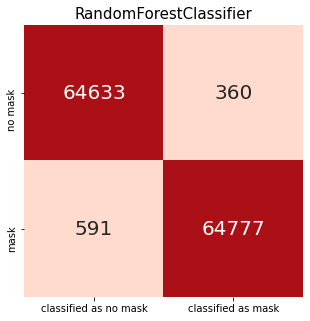

>... Saving figure Confusion_Matrix_RandomForestClassifier_24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for SGDClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

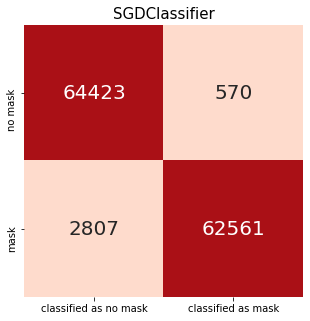

>... Saving figure Confusion_Matrix_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for RandomForestClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24


                         RandomForestClassifier          SGDClassifier
precision score                           0.994                  0.991
recall score                              0.991                  0.957
cross validation scores   [0.993, 0.992, 0.993]  [0.971, 0.972, 0.979]
cross validation mean                     0.993                  0.974
cross validation std                    0.00047                0.00356
eval run time in seconds                5271.53                  199.6 




<Figure size 432x288 with 0 Axes>

In [55]:
### Show evals 
show_evals_dim_red(pix_res=pix, dim_red=False, error_table=True, conf_matrix=True, eval_metrics=True)

>... Error table pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Print error table for pixel resolution 24 of SGDClassifier


                Filename picture ID  Label Predicted      Error Type
38740         KAGGLE/Image_1000.jpg  False      True  False positive
35807         KAGGLE/Image_1012.jpg  False      True  False positive
42831         KAGGLE/Image_1029.jpg  False      True  False positive
84675         KAGGLE/Image_1048.jpg  False      True  False positive
17754         KAGGLE/Image_1049.jpg  False      True  False positive
...                             ...    ...       ...             ...
72690   NVIDIA/69000/69827_Mask.jpg   True     False  False negative
43818   NVIDIA/69000/69881_Mask.jpg   True     False  False negative
102815  NVIDIA/69000/69885_Mask.jpg   True     False  False negative
127598  NVIDIA/69000/69924_Mask.jpg   True     False  False negative
6022    NVIDIA/69000/69983_Mask.jpg   True     False  False negative

[4968 rows x 4

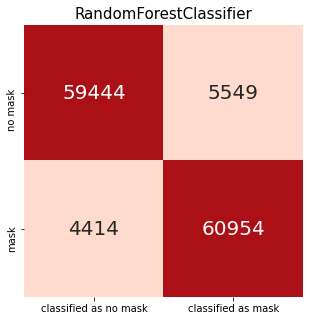

>... Saving figure Confusion_Matrix_RandomForestClassifier_24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for SGDClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

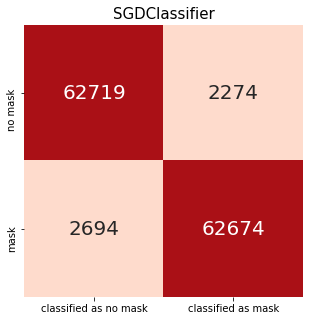

>... Saving figure Confusion_Matrix_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for RandomForestClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24


                         RandomForestClassifier          SGDClassifier
precision score                           0.917                  0.965
recall score                              0.932                  0.959
cross validation scores   [0.925, 0.923, 0.922]  [0.956, 0.967, 0.962]
cross validation mean                     0.923                  0.962
cross validation std                    0.00125                 0.0045
eval run time in seconds                 752.37                  68.95 




<Figure size 432x288 with 0 Axes>

In [59]:
show_evals_dim_red(pix_res=pix, dim_red=True, error_table=True, conf_matrix=True, eval_metrics=True)

<br>
<br>
<br>
<br>
<br>
<br>

### Hyper-Paramter tuning on reduced test set for accuracy

In principal a new short round of accuracy hyper-parameter tuning could be performed here, because the classifiers might perform better on the reduced feature data set with slightly different set of hyperparameters. However, as the accuarcy loss due to the PCA is not very large we are not following up on that here due to run-time and scope limitations of our project. 

<br>
<br>
<br>
<br>
<br>
<br>

### Using different pixel resolution as input to improve speed

In the following code chunks different Pixel Resolutions are used as an input inorder to estimate how much of a difference the pixel resolution makes. All data sets are first transformed via a PCA - then all are cross-validated as the 24 pixel resolution above. The question we want to answer is: Does a higher pixel resolution leads a higher accuracy, even though a PCA is used, and how much additional run-time do we have to invest.

<br>
<br>
<br>
<br>
<br>
<br>

# Final evaluation on test set

In the following code chunks the performance on the test set is evaluated. In the first part both classifiers are trained and tested on the data set with all features included. In the second part both classifiers are trained and tested against a data set that include only the features that account for 95% of the variance of the data set.

In [12]:
# Specify pixel resolution
pix = 24
pix_res = 24

# Check availiability of pixel resolution
check_pixels(pix)

# Load and split the data
rgb_full_train, rgb_full_test, labels_train_tf, labels_test_tf, pic_ids_train, pic_ids_test = load_data(pix_res=pix)

The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays
>... Data sucessfully split into test and train data


### 1. Part: Baseline classifiers on test data set with all features (no PCA)

In [8]:
# Define Classifiers
# Importing all classifiers again (for running only hyper-parameter tuning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Random Forest
classifier_RandomForest_baseline = RandomForestClassifier(random_state=42)

# SGD
classifier_SGD_baseline = SGDClassifier(random_state=42)


# Combine classifiers to a list through which you can loop
classifiers_baseline= [classifier_RandomForest_baseline, classifier_SGD_baseline]

In [9]:
# Defining save paths
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME

# Train Classifier on Train set
for classifier_x in classifiers_baseline:
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting", classifier_name)
    start_time = timeit.default_timer()
    
    #Train model
    classifier_x.fit(rgb_full_train, labels_train_tf)
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    
    # Store run-time info
    run_time_info = {}
    run_time_info[str(pix)] = round(time_elapsed, 3)
    if full_data_switch_on == True:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_test_baseline_full_"+str(classifier_name)+"_"+str(pix)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_test_baseline_dummy_toy_"+str(classifier_name)+"_"+str(pix)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(run_time_info, file)
    file.close()
    print("Successfully stored in: {}".format(FILE_PATH))
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,2)))

>... Starting RandomForestClassifier
Successfully stored in: 03_output/03_run_time_scores/run_time_test_baseline_full_RandomForestClassifier_24.pkl
>... Classifier RandomForestClassifier sucessfully trained in 341.1 seconds.
>... Starting SGDClassifier
Successfully stored in: 03_output/03_run_time_scores/run_time_test_baseline_full_SGDClassifier_24.pkl
>... Classifier SGDClassifier sucessfully trained in 66.67 seconds.


In [13]:
# Evaluate Classifier on Test set
# Define Evaluation function
for classifier_x in classifiers_baseline:
    # Import metrics and validation methods
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, precision_recall_curve
    import matplotlib.pyplot as plt 
    
    # Defining save paths
    SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
    SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
    SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
    

    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting evaluation of", classifier_name)
    
    # Predictions
    print(">... Starting prediction for", classifier_name)
    start_time = timeit.default_timer()
    pred=classifier_x.predict(rgb_full_test)
    time_elapsed = timeit.default_timer() - start_time
    
    
    
    # Store evaluation metrics
    print(">... Saving evaluation metric of", classifier_name)
    # Initialize eval dictionary and store values
    evaluation_scores = {}
    evaluation_scores["Precision Score"] = precision_score(labels_test_tf, pred).round(3)
    evaluation_scores["Recall Score"] = recall_score(labels_test_tf, pred).round(3)
    evaluation_scores["Accuracy Score"] = accuracy_score(labels_test_tf, pred).round(3)
    evaluation_scores["Confusion matrix"] = confusion_matrix(labels_test_tf, pred)
    evaluation_scores["Prediction time in seconds"] = round(time_elapsed, 3)
    

    
    # Storing evaluations scores into pickle file to access them later
    if full_data_switch_on == True: 
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_test_baseline_" + str(classifier_name) + "_full_" + str(pix) + ".pkl")
    elif full_data_switch_on == False:
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_test_baseline_" + str(classifier_name) + "_dummy_toy_" + str(pix) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(EVAL_FILE_PATH,"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    print(">... Evaluation scores successfully stored in: {}".format(EVAL_FILE_PATH))
    
    
    # Create output array with error-types and pic ids
    # Combine pics ids, labels and predicted values
    print(">... Starting to create output array with error-types for more transparency for classifier {}.".format(classifier_name))
    output_dict = {}
    pred_tf = (pred == 1)
    output_array = np.c_[pic_ids_test, labels_test_tf, pred_tf]
    
    # Create error array with specific error type
    err_type_arr = np.array([])
    for i in range(len(output_array)):
        if output_array[i,1] == "True" and output_array[i,2] == "False":
            err_type_arr = np.append(err_type_arr, "False negative")
        elif output_array[i,1] == "False" and output_array[i,2] == "True":
            err_type_arr = np.append(err_type_arr, "False positive")
        else:
            err_type_arr = np.append(err_type_arr, "No error")
    
    # Combine error into and output array into pandas data frame
    error_table_pd = pd.DataFrame(output_array)
    error_table_pd.rename(columns = {0:'Filename picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
    error_table_pd["Error Type"] = err_type_arr
    
    # Saving all in dictionary
    output_dict["error_table"] = error_table_pd
    
    # Saving dictionary of error table
    if full_data_switch_on == True: 
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_test_baseline_" + str(classifier_name) + "_full_" + str(pix) + ".pkl")
    elif full_data_switch_on == False:
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_test_baseline_" + str(classifier_name) + "_dummy_toy_" + str(pix) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(ERROR_TABLE_FILE_PATH,"wb")
    pickle.dump(output_dict, file)
    file.close()
    print(">... Error table dictionary successfully stored in: {}".format(ERROR_TABLE_FILE_PATH))
    
    
    # Output message
    print(">... Evaluation of classifier {} sucessfully finished in {} seconds.".format(classifier_name, round(time_elapsed,2)))


>... Starting evaluation of RandomForestClassifier
>... Starting prediction for RandomForestClassifier
>... Saving evaluation metric of RandomForestClassifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_test_baseline_RandomForestClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier RandomForestClassifier.
>... Error table dictionary successfully stored in: 03_output/02_error_tables/error_table_pd_test_baseline_RandomForestClassifier_full_24.pkl
>... Evaluation of classifier RandomForestClassifier sucessfully finished in 0.53 seconds.
>... Starting evaluation of SGDClassifier
>... Starting prediction for SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_test_baseline_SGDClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier S

In [14]:
# Loading and Showing Error Table
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME

###### Error Table ######
# List all files of error table folder
filenames_error_table = []
for root, dirs, files in os.walk(SAVE_PATH_ERROR_TABLE):
    for name in files:
        filenames_error_table.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_error_table_pix = []
for i in range(len(filenames_error_table)):
    if str(pix_res) in filenames_error_table[i] and "_test_baseline_" in filenames_error_table[i]:
        filenames_error_table_pix.append(filenames_error_table[i])

# Display error table
help_dict_error = {}
for i in range(len(filenames_error_table_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_error_table_pix[i]:
        # Find pixel resolution in filenames
        search_term = "error_table_pd_"
        pos_start = filenames_error_table_pix[i].find(search_term)
        pos_end = filenames_error_table_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_error_table_pix[i]:
        # Find pixel resolution in filenames
        search_term = "error_table_pd_"
        pos_start = filenames_error_table_pix[i].find(search_term)
        pos_end = filenames_error_table_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

    # Load pickle-file and display pandas data frame filtered to error types
    dict_error_table = pickle.load(open(filenames_error_table_pix[i],"rb"))
    print(">... Error table pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    error_table_pd = dict_error_table["error_table"]
    filter_options = ["False positive", "False negative"]
    print(">... Print error table for pixel resolution {} of {}\n\n".format(pix_res, classifier_name))
    help_dict_error[classifier_name] = error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"])
    print(error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"]))
    print("\n\n")

>... Error table pickle file successfully loaded for test_baseline_SGDClassifier and pixel resolution 24
>... Print error table for pixel resolution 24 of test_baseline_SGDClassifier


                          Filename picture ID  Label Predicted      Error Type
12481                   KAGGLE/Image_3344.jpg  False      True  False positive
7585   NVIDIA/04000/04500_Mask_Nose_Mouth.jpg  False      True  False positive
3226   NVIDIA/17000/17611_Mask_Nose_Mouth.jpg  False      True  False positive
4076   NVIDIA/48000/48539_Mask_Mouth_Chin.jpg  False      True  False positive
13488  NVIDIA/51000/51779_Mask_Nose_Mouth.jpg  False      True  False positive
...                                       ...    ...       ...             ...
13550             NVIDIA/69000/69933_Mask.jpg   True     False  False negative
10679             NVIDIA/69000/69955_Mask.jpg   True     False  False negative
5035              NVIDIA/69000/69970_Mask.jpg   True     False  False negative
6389              NVIDIA/

In [15]:
print(">... Error Table Random Forest")
help_dict_error["test_baseline_RandomForestClassifier"]

>... Error Table Random Forest


,Filename picture ID,Label,Predicted,Error Type
7059,KAGGLE/Image_12.jpg,False,True,False positive
9048,KAGGLE/Image_1665.jpg,False,True,False positive
13203,KAGGLE/Image_1863.jpg,False,True,False positive
6505,KAGGLE/Image_1889.jpg,False,True,False positive
11385,KAGGLE/Image_2201.jpg,False,True,False positive
...,...,...,...,...
7698,KAGGLE/Image_9924.jpg,True,False,False negative
4715,NVIDIA/14000/14315_Mask.jpg,True,False,False negative
14454,NVIDIA/30000/30369_Mask.jpg,True,False,False negative
12155,NVIDIA/39000/39720_Mask.jpg,True,False,False negative


In [16]:
print(">... Error Table SGD")
help_dict_error["test_baseline_SGDClassifier"]

>... Error Table SGD


,Filename picture ID,Label,Predicted,Error Type
12481,KAGGLE/Image_3344.jpg,False,True,False positive
7585,NVIDIA/04000/04500_Mask_Nose_Mouth.jpg,False,True,False positive
3226,NVIDIA/17000/17611_Mask_Nose_Mouth.jpg,False,True,False positive
4076,NVIDIA/48000/48539_Mask_Mouth_Chin.jpg,False,True,False positive
13488,NVIDIA/51000/51779_Mask_Nose_Mouth.jpg,False,True,False positive
...,...,...,...,...
13550,NVIDIA/69000/69933_Mask.jpg,True,False,False negative
10679,NVIDIA/69000/69955_Mask.jpg,True,False,False negative
5035,NVIDIA/69000/69970_Mask.jpg,True,False,False negative
6389,NVIDIA/69000/69985_Mask.jpg,True,False,False negative


>... Eval metrics pickle file successfully loaded for test_baseline_SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for test_baseline_SGDClassifier and pixel resolution 24


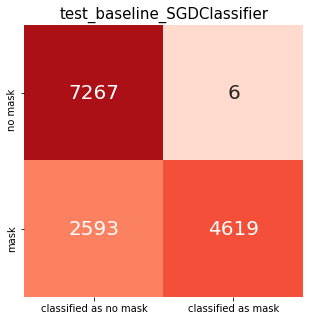

>... Saving figure Confusion_Matrix_test_baseline_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for test_baseline_RandomForestClassifier and pixel resolution 24
>... Displaying confusion matrix for test_baseline_RandomForestClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

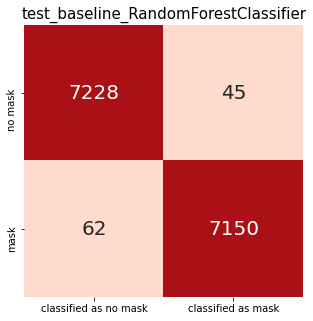

>... Saving figure Confusion_Matrix_test_baseline_RandomForestClassifier_24


<Figure size 432x288 with 0 Axes>

In [17]:
# Loading and Showing Confusuion Matrix
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
pix_res=24

###### Confusion Matrix ######
# List all files of eval dictionary folder
filenames_eval_dics = []
for root, dirs, files in os.walk(SAVE_PATH_EVAL):
    for name in files:
        filenames_eval_dics.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_eval_dics_pix = []
for i in range(len(filenames_eval_dics)):
    if str(pix_res) in filenames_eval_dics[i] and "_test_baseline_" in filenames_eval_dics[i]:
        filenames_eval_dics_pix.append(filenames_eval_dics[i])

# Display confusion matrix
for i in range(len(filenames_eval_dics_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

    # Load pikle-file and display pandas data frame filtered to error types
    dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
    print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    # Extract confusion matrix data into data frame
    cm_data = dict_eval_metrics["Confusion matrix"]
    plot_matrix = pd.DataFrame(cm_data, columns = ["classified as no mask", "classified as mask"],
                        index = ["no mask", "mask"])

    # Actual plot with seaborn and saving figure with different file names depending on switch
    print(">... Displaying confusion matrix for {} and pixel resolution {}".format(classifier_name, pix_res))
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        plt.show()
        save_fig("99_CM_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
    elif "full" in filenames_eval_dics_pix[i]:
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        plt.show()
        save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

In [18]:
# Loading and Showing Eval Metrics
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME
pix_res=24

###### Eval Metrics ######
# List all files of eval dictionary folder
filenames_eval_dics = []
for root, dirs, files in os.walk(SAVE_PATH_EVAL):
    for name in files:
        filenames_eval_dics.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_eval_dics_pix = []
for i in range(len(filenames_eval_dics)):
    if str(pix_res) in filenames_eval_dics[i] and "_test_baseline_" in filenames_eval_dics[i]:
        filenames_eval_dics_pix.append(filenames_eval_dics[i])

eval_metrics = {}
for i in range(len(filenames_eval_dics_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")


    # Load pikle-file and display pandas data frame filtered to error types
    dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
    print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    # Extract eval metrics into data frame
    precision_score = dict_eval_metrics["Precision Score"]
    recall_score = dict_eval_metrics["Recall Score"]
    accuracy_score = dict_eval_metrics["Accuracy Score"]
    eval_run_time = dict_eval_metrics["Prediction time in seconds"]

    #Storing in eval_metrics library
    eval_metrics[classifier_name] = [precision_score,
                                     recall_score,
                                     accuracy_score,
                                     eval_run_time]

# Output table of metrics
print(">... Display eval metrics table for pixel resolution {}\n\n".format(pix_res))
index = ["precision score", "recall score", "accuracy_score", "prediction time in seconds"]
table_eval_metrics = pd.DataFrame(eval_metrics, index)
table_eval_metrics

>... Eval metrics pickle file successfully loaded for test_baseline_SGDClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for test_baseline_RandomForestClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24




,test_baseline_SGDClassifier,test_baseline_RandomForestClassifier
precision score,0.999,0.994
recall score,0.640,0.991
accuracy_score,0.821,0.993
prediction time in seconds,0.020,0.532


<br>
<br>
<br>
<br>
<br>
<br>
<br>

### 2. Part: Tuned classifiers on data set with all features (no PCA)

In [19]:
# Show best parameters again
best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_RandomForestClassifier_24.pkl","rb"))
print("RandomForest: ",best_params_output)

best_params_output = pickle.load(open("03_output/07_hyptertuning_best_params/best_params_grid_search_full_SGDClassifier_24.pkl","rb"))
print("SGD: ",best_params_output)

RandomForest:  {'Grid_Search_Best_Params': {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 250}}
SGD:  {'Grid_Search_Best_Params': {'alpha': 0.01, 'max_iter': 100, 'penalty': 'l2'}}


In [20]:
# Define Classifiers
# Importing all classifiers again (for running only hyper-parameter tuning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Random Forest
classifier_RandomForest_tuned_accuracy = RandomForestClassifier(random_state=42,
                                                           n_estimators=250,
                                                           max_features="auto",
                                                           bootstrap=False)

# SGD
classifier_SGD_tuned_accuracy = SGDClassifier(random_state=42,
                                         penalty="l2",
                                         alpha=0.01,
                                         max_iter=100)


# Combine classifiers to a list through which you can loop
classifiers_tuned_accuracy= [classifier_RandomForest_tuned_accuracy, classifier_SGD_tuned_accuracy]
pix = 24

In [21]:
# Defining save paths
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER

# Train Classifier on Train set
for classifier_x in classifiers_tuned_accuracy:
       
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    
    #Train model
    print(">... Starting", classifier_name)
    start_time = timeit.default_timer()
    classifier_x.fit(rgb_full_train, labels_train_tf)
    time_elapsed = timeit.default_timer() - start_time
    
    # Store run-time info
    run_time_info = {}
    run_time_info[str(pix)] = round(time_elapsed, 3)
    if full_data_switch_on == True:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_test_full_"+str(classifier_name)+"_"+str(pix)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_test_dummy_toy_"+str(classifier_name)+"_"+str(pix)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(run_time_info, file)
    file.close()
    print("Successfully stored in: {}".format(FILE_PATH))
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,2)))

>... Starting RandomForestClassifier
Successfully stored in: 03_output/06_run_time_scores_hyptertuning/run_time_test_full_RandomForestClassifier_24.pkl
>... Classifier RandomForestClassifier sucessfully trained in 1360.78 seconds.
>... Starting SGDClassifier
Successfully stored in: 03_output/06_run_time_scores_hyptertuning/run_time_test_full_SGDClassifier_24.pkl
>... Classifier SGDClassifier sucessfully trained in 32.57 seconds.


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [22]:
# Evaluate Classifier on Test set
# Define Evaluation function
for classifier_x in classifiers_tuned_accuracy:
    # Import metrics and validation methods
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, precision_recall_curve
    import matplotlib.pyplot as plt 
    
    # Defining save paths
    SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
    SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
    SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    
    # Predictions
    print(">... Starting prediction for", classifier_name)
    start_time = timeit.default_timer()
    pred=classifier_x.predict(rgb_full_test) # cross value prediction with 3 folds
    time_elapsed = timeit.default_timer() - start_time
    
    # Store evaluation metrics
    print(">... Saving evaluation metric of", classifier_name)
    # Initialize eval dictionary and store values
    evaluation_scores = {}
    evaluation_scores["Precision Score"] = precision_score(labels_test_tf, pred).round(3)
    evaluation_scores["Recall Score"] = recall_score(labels_test_tf, pred).round(3)
    evaluation_scores["Accuracy Score"] = accuracy_score(labels_test_tf, pred).round(3)
    evaluation_scores["Confusion matrix"] = confusion_matrix(labels_test_tf, pred) 
    evaluation_scores["Prediction time in seconds"] = round(time_elapsed, 3)
    
    # Storing evaluations scores into pickle file to access them later
    if full_data_switch_on == True: 
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_test_" + str(classifier_name) + "_full_" + str(pix) + ".pkl")
    elif full_data_switch_on == False:
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_test_" + str(classifier_name) + "_dummy_toy_" + str(pix) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(EVAL_FILE_PATH,"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    print(">... Evaluation scores successfully stored in: {}".format(EVAL_FILE_PATH))
    
    
    # Create output array with error-types and pic ids
    # Combine pics ids, labels and predicted values
    print(">... Starting to create output array with error-types for more transparency for classifier {}.".format(classifier_name))
    output_dict = {}
    pred_tf = (pred == 1)
    output_array = np.c_[pic_ids_test, labels_test_tf, pred_tf]
    
    # Create error array with specific error type
    err_type_arr = np.array([])
    for i in range(len(output_array)):
        if output_array[i,1] == "True" and output_array[i,2] == "False":
            err_type_arr = np.append(err_type_arr, "False negative")
        elif output_array[i,1] == "False" and output_array[i,2] == "True":
            err_type_arr = np.append(err_type_arr, "False positive")
        else:
            err_type_arr = np.append(err_type_arr, "No error")
    
    # Combine error into and output array into pandas data frame
    error_table_pd = pd.DataFrame(output_array)
    error_table_pd.rename(columns = {0:'Filename picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
    error_table_pd["Error Type"] = err_type_arr
    
    # Saving all in dictionary
    output_dict["error_table"] = error_table_pd
    
    # Saving dictionary of error table
    if full_data_switch_on == True: 
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_test_" + str(classifier_name) + "_full_" + str(pix) + ".pkl")
    elif full_data_switch_on == False:
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_test_" + str(classifier_name) + "_dummy_toy_" + str(pix) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(ERROR_TABLE_FILE_PATH,"wb")
    pickle.dump(output_dict, file)
    file.close()
    print(">... Error table dictionary successfully stored in: {}".format(ERROR_TABLE_FILE_PATH))
    
    
    # Output message
    print(">... Evaluation of classifier {} sucessfully finished in {} seconds.".format(classifier_name, round(time_elapsed,2)))


>... Starting prediction for RandomForestClassifier
>... Saving evaluation metric of RandomForestClassifier
>... Evaluation scores successfully stored in: 03_output/04_eval_scores_hypertuning/evaluation_scores_test_RandomForestClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier RandomForestClassifier.
>... Error table dictionary successfully stored in: 03_output/05_error_tables_hyptertuning/error_table_pd_test_RandomForestClassifier_full_24.pkl
>... Evaluation of classifier RandomForestClassifier sucessfully finished in 1.16 seconds.
>... Starting prediction for SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/04_eval_scores_hypertuning/evaluation_scores_test_SGDClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier SGDClassifier.
>... Error table dictionary successfully stored in: 03_output/05_erro

In [23]:
# Show Error Tables
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER

###### Error Table ######
# List all files of error table folder
filenames_error_table = []
for root, dirs, files in os.walk(SAVE_PATH_ERROR_TABLE):
    for name in files:
        filenames_error_table.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_error_table_pix = []
for i in range(len(filenames_error_table)):
    if str(pix_res) in filenames_error_table[i] and "_test_" in filenames_error_table[i] and "_reduced_" not in filenames_error_table[i]:
        filenames_error_table_pix.append(filenames_error_table[i])

# Display error table
help_dict_error = {}
for i in range(len(filenames_error_table_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_error_table_pix[i]:
        # Find pixel resolution in filenames
        search_term = "error_table_pd_"
        pos_start = filenames_error_table_pix[i].find(search_term)
        pos_end = filenames_error_table_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_error_table_pix[i]:
        # Find pixel resolution in filenames
        search_term = "error_table_pd_"
        pos_start = filenames_error_table_pix[i].find(search_term)
        pos_end = filenames_error_table_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

    # Load pickle-file and display pandas data frame filtered to error types
    dict_error_table = pickle.load(open(filenames_error_table_pix[i],"rb"))
    print(">... Error table pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    error_table_pd = dict_error_table["error_table"]
    filter_options = ["False positive", "False negative"]
    print(">... Print error table for pixel resolution {} of {}\n\n".format(pix_res, classifier_name))
    help_dict_error[classifier_name] = error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"])
    print(error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"]))
    print("\n\n")

>... Error table pickle file successfully loaded for test_RandomForestClassifier and pixel resolution 24
>... Print error table for pixel resolution 24 of test_RandomForestClassifier


               Filename picture ID  Label Predicted      Error Type
7059           KAGGLE/Image_12.jpg  False      True  False positive
9048         KAGGLE/Image_1665.jpg  False      True  False positive
12667        KAGGLE/Image_1719.jpg  False      True  False positive
13203        KAGGLE/Image_1863.jpg  False      True  False positive
6505         KAGGLE/Image_1889.jpg  False      True  False positive
...                            ...    ...       ...             ...
861    NVIDIA/18000/18757_Mask.jpg   True     False  False negative
14454  NVIDIA/30000/30369_Mask.jpg   True     False  False negative
12155  NVIDIA/39000/39720_Mask.jpg   True     False  False negative
14133  NVIDIA/57000/57009_Mask.jpg   True     False  False negative
6969   NVIDIA/68000/68639_Mask.jpg   True     False  False negative

In [24]:
print(">... Error Table Random Forest")
help_dict_error["test_RandomForestClassifier"]

>... Error Table Random Forest


,Filename picture ID,Label,Predicted,Error Type
7059,KAGGLE/Image_12.jpg,False,True,False positive
9048,KAGGLE/Image_1665.jpg,False,True,False positive
12667,KAGGLE/Image_1719.jpg,False,True,False positive
13203,KAGGLE/Image_1863.jpg,False,True,False positive
6505,KAGGLE/Image_1889.jpg,False,True,False positive
...,...,...,...,...
861,NVIDIA/18000/18757_Mask.jpg,True,False,False negative
14454,NVIDIA/30000/30369_Mask.jpg,True,False,False negative
12155,NVIDIA/39000/39720_Mask.jpg,True,False,False negative
14133,NVIDIA/57000/57009_Mask.jpg,True,False,False negative


In [25]:
print(">... Error Table SGD")
help_dict_error["test_SGDClassifier"]

>... Error Table SGD


,Filename picture ID,Label,Predicted,Error Type
2884,KAGGLE/Image_1075.jpg,False,True,False positive
7172,KAGGLE/Image_1162.jpg,False,True,False positive
1843,KAGGLE/Image_1193.jpg,False,True,False positive
7059,KAGGLE/Image_12.jpg,False,True,False positive
14460,KAGGLE/Image_1296.jpg,False,True,False positive
...,...,...,...,...
8846,NVIDIA/51000/51563_Mask.jpg,True,False,False negative
14466,NVIDIA/56000/56507_Mask.jpg,True,False,False negative
13004,NVIDIA/57000/57731_Mask.jpg,True,False,False negative
11466,NVIDIA/63000/63466_Mask.jpg,True,False,False negative


>... Eval metrics pickle file successfully loaded for test_SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for test_SGDClassifier and pixel resolution 24


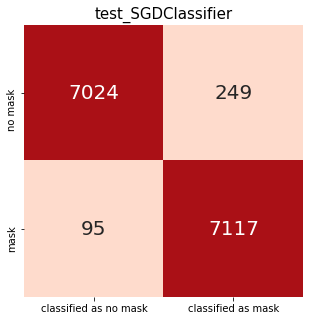

>... Saving figure Confusion_Matrix_test_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for test_RandomForestClassifier and pixel resolution 24
>... Displaying confusion matrix for test_RandomForestClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

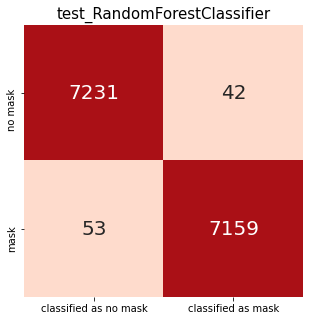

>... Saving figure Confusion_Matrix_test_RandomForestClassifier_24


<Figure size 432x288 with 0 Axes>

In [26]:
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
pix_res=24

###### Confusion Matrix ######
# List all files of eval dictionary folder
filenames_eval_dics = []
for root, dirs, files in os.walk(SAVE_PATH_EVAL):
    for name in files:
        filenames_eval_dics.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_eval_dics_pix = []
for i in range(len(filenames_eval_dics)):
    if str(pix_res) in filenames_eval_dics[i] and "_test_" in filenames_eval_dics[i] and "_reduced_" not in filenames_eval_dics[i]:
        filenames_eval_dics_pix.append(filenames_eval_dics[i])

# Display confusion matrix
for i in range(len(filenames_eval_dics_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

    # Load pikle-file and display pandas data frame filtered to error types
    dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
    print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    # Extract confusion matrix data into data frame
    cm_data = dict_eval_metrics["Confusion matrix"]
    plot_matrix = pd.DataFrame(cm_data, columns = ["classified as no mask", "classified as mask"],
                        index = ["no mask", "mask"])

    # Actual plot with seaborn and saving figure with different file names depending on switch
    print(">... Displaying confusion matrix for {} and pixel resolution {}".format(classifier_name, pix_res))
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        plt.show()
        save_fig("99_CM_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
    elif "full" in filenames_eval_dics_pix[i]:
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        plt.show()
        save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

In [27]:
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
pix_res=24
###### Eval Metrics ######
# List all files of eval dictionary folder
filenames_eval_dics = []
for root, dirs, files in os.walk(SAVE_PATH_EVAL):
    for name in files:
        filenames_eval_dics.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_eval_dics_pix = []
for i in range(len(filenames_eval_dics)):
    if str(pix_res) in filenames_eval_dics[i] and "_test_" in filenames_eval_dics[i] and "_reduced_" not in filenames_eval_dics[i]:
        filenames_eval_dics_pix.append(filenames_eval_dics[i])

eval_metrics = {}
for i in range(len(filenames_eval_dics_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")


    # Load pikle-file and display pandas data frame filtered to error types
    dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
    print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    # Extract eval metrics into data frame
    precision_score = dict_eval_metrics["Precision Score"]
    recall_score = dict_eval_metrics["Recall Score"]
    accuracy_score = dict_eval_metrics["Accuracy Score"]
    eval_run_time = dict_eval_metrics["Prediction time in seconds"]

    #Storing in eval_metrics library
    eval_metrics[classifier_name] = [precision_score,
                                     recall_score,
                                     accuracy_score,
                                     eval_run_time]

# Output table of metrics
print(">... Display eval metrics table for pixel resolution {}\n\n".format(pix_res))
index = ["precision score", "recall score", "accuracy_score", "prediction time in seconds"]
table_eval_metrics = pd.DataFrame(eval_metrics, index)
table_eval_metrics

>... Eval metrics pickle file successfully loaded for test_SGDClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for test_RandomForestClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24




,test_SGDClassifier,test_RandomForestClassifier
precision score,0.966,0.994
recall score,0.987,0.993
accuracy_score,0.976,0.993
prediction time in seconds,0.018,1.157


<br>
<br>
<br>
<br>
<br>
<br>
<br>

### 3. Part: Tuned classifier on data set with limited features (PCA included)

In [28]:
# Loading data set for principal component analysis.
pix_res = 24
# Checking pixel resolution
check_pixels(pix_res)


### Loading full data-set without splitting into test and train ###
# Define datafile path
if full_data_switch_on == True:
    DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_full_" + str(pix_res) + ".pkl")
elif full_data_switch_on == False:
    DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_dummy_toy_" + str(pix_res) + ".pkl")
else:
    raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")

# Load pickle file
pic_data = pickle.load(open(DATAFILE_PATH,"rb"))
print(">... Pickle datafile successfully loaded: ", DATAFILE_PATH)

# Copying dictionary data into separate data frames
rgb_data, labels, pic_ids = pic_data["rgb_data"], pic_data["labels"], pic_data["pic_ids"]
print(">... Pickle dictionary sucessfully separated into individuals arrays")

The following pixels are available for the full data set:  [16, 24, 32]
The specified pixel resolution 24 is available!
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_full_24.pkl
>... Pickle dictionary sucessfully separated into individuals arrays


In [29]:
# Implementing PCA
from sklearn.decomposition import PCA

# Defining how much variance you want to have explained:
threshold = 0.95

pca = PCA()
pca.fit(rgb_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= threshold) + 1

In [30]:
# Showing number of features necessary to reach 95% variance explained
print("Features necessary to explain {}% variance: {}".format(threshold*100, d))

Features necessary to explain 95.0% variance: 184


In [31]:
# Reducing the original data set
pca = PCA(n_components=threshold)
rgb_data_reduced = pca.fit_transform(rgb_data)

In [32]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split
rgb_full_train, rgb_full_test, rgb_reduced_train, rgb_reduced_test, labels_train, labels_test, pic_ids_train, pic_ids_test = train_test_split(rgb_data, rgb_data_reduced, labels, pic_ids, test_size=0.10, random_state=42)
print(">... Data sucessfully split into test and train data")

# redefining labels as True False
labels_train_tf = (labels_train == 1)
labels_test_tf = (labels_test == 1)

>... Data sucessfully split into test and train data


In [33]:
# Define Classifiers
# Importing all classifiers again (for running only hyper-parameter tuning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Random Forest
classifier_RandomForest_tuned_speed = RandomForestClassifier(random_state=42,
                                                           n_estimators=250,
                                                           max_features="auto",
                                                           bootstrap=False)

# SGD
classifier_SGD_tuned_speed = SGDClassifier(random_state=42,
                                         penalty="l2",
                                         alpha=0.01,
                                         max_iter=100)


# Combine classifiers to a list through which you can loop
classifiers_tuned_speed= [classifier_RandomForest_tuned_speed, classifier_SGD_tuned_speed]
pix = 24

In [34]:
# Defining save paths
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER

# Train Classifier on Train set
for classifier_x in classifiers_tuned_speed:
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    
    
    #Train model
    print(">... Starting", classifier_name)
    start_time = timeit.default_timer()
    classifier_x.fit(rgb_reduced_train, labels_train_tf)
    time_elapsed = timeit.default_timer() - start_time
    
    # Store run-time info
    run_time_info = {}
    run_time_info[str(pix)] = round(time_elapsed, 3)
    if full_data_switch_on == True:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_test_full_reduced_"+str(classifier_name)+"_"+str(pix)+".pkl")
    elif full_data_switch_on == False:
        FILE_PATH = os.path.join(SAVE_PATH_RUN_TIME + "/run_time_test_dummy_toy_reduced_"+str(classifier_name)+"_"+str(pix)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    file = open(FILE_PATH,"wb")
    pickle.dump(run_time_info, file)
    file.close()
    print("Successfully stored in: {}".format(FILE_PATH))
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,2)))

>... Starting RandomForestClassifier
Successfully stored in: 03_output/06_run_time_scores_hyptertuning/run_time_test_full_reduced_RandomForestClassifier_24.pkl
>... Classifier RandomForestClassifier sucessfully trained in 724.28 seconds.
>... Starting SGDClassifier
Successfully stored in: 03_output/06_run_time_scores_hyptertuning/run_time_test_full_reduced_SGDClassifier_24.pkl
>... Classifier SGDClassifier sucessfully trained in 5.11 seconds.


/home/thilosander/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [35]:
# Evaluate Classifier on Test set
# Define Evaluation function
for classifier_x in classifiers_tuned_speed:
    # Import metrics and validation methods
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, plot_confusion_matrix, precision_recall_curve
    import matplotlib.pyplot as plt 
    
    # Defining save paths
    SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
    SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
    SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER
    
    # Start timer
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting evaluation of", classifier_name)
    
    # Predictions
    print(">... Starting prediction for", classifier_name)
    start_time = timeit.default_timer()
    pred=classifier_x.predict(rgb_reduced_test) # cross value prediction with 3 folds
    time_elapsed = timeit.default_timer() - start_time
    
    # Store evaluation metrics
    print(">... Saving evaluation metric of", classifier_name)
    # Initialize eval dictionary and store values
    evaluation_scores = {}
    evaluation_scores["Precision Score"] = precision_score(labels_test_tf, pred).round(3)
    evaluation_scores["Recall Score"] = recall_score(labels_test_tf, pred).round(3)
    evaluation_scores["Accuracy Score"] = accuracy_score(labels_test_tf, pred).round(3)
    evaluation_scores["Confusion matrix"] = confusion_matrix(labels_test_tf, pred)
    evaluation_scores["Prediction time in seconds"] = round(time_elapsed, 3)
    
    # Storing evaluations scores into pickle file to access them later
    if full_data_switch_on == True: 
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_test_reduced_" + str(classifier_name) + "_full_" + str(pix) + ".pkl")
    elif full_data_switch_on == False:
        EVAL_FILE_PATH = os.path.join(SAVE_PATH_EVAL + "/evaluation_scores_test_reduced_" + str(classifier_name) + "_dummy_toy_" + str(pix) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(EVAL_FILE_PATH,"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    print(">... Evaluation scores successfully stored in: {}".format(EVAL_FILE_PATH))
    
    
    # Create output array with error-types and pic ids
    # Combine pics ids, labels and predicted values
    print(">... Starting to create output array with error-types for more transparency for classifier {}.".format(classifier_name))
    output_dict = {}
    pred_tf = (pred == 1)
    output_array = np.c_[pic_ids_test, labels_test_tf, pred_tf]
    
    # Create error array with specific error type
    err_type_arr = np.array([])
    for i in range(len(output_array)):
        if output_array[i,1] == "True" and output_array[i,2] == "False":
            err_type_arr = np.append(err_type_arr, "False negative")
        elif output_array[i,1] == "False" and output_array[i,2] == "True":
            err_type_arr = np.append(err_type_arr, "False positive")
        else:
            err_type_arr = np.append(err_type_arr, "No error")
    
    # Combine error into and output array into pandas data frame
    error_table_pd = pd.DataFrame(output_array)
    error_table_pd.rename(columns = {0:'Filename picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
    error_table_pd["Error Type"] = err_type_arr
    
    # Saving all in dictionary
    output_dict["error_table"] = error_table_pd
    
    # Saving dictionary of error table
    if full_data_switch_on == True: 
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_test_reduced_" + str(classifier_name) + "_full_" + str(pix) + ".pkl")
    elif full_data_switch_on == False:
        ERROR_TABLE_FILE_PATH = os.path.join(SAVE_PATH_ERROR_TABLE + "/error_table_pd_test_reduced_" + str(classifier_name) + "_dummy_toy_" + str(pix) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(ERROR_TABLE_FILE_PATH,"wb")
    pickle.dump(output_dict, file)
    file.close()
    print(">... Error table dictionary successfully stored in: {}".format(ERROR_TABLE_FILE_PATH))
    
    
    # Output message
    print(">... Evaluation of classifier {} sucessfully finished in {} seconds.".format(classifier_name, round(time_elapsed,3)))


>... Starting evaluation of RandomForestClassifier
>... Starting prediction for RandomForestClassifier
>... Saving evaluation metric of RandomForestClassifier
>... Evaluation scores successfully stored in: 03_output/04_eval_scores_hypertuning/evaluation_scores_test_reduced_RandomForestClassifier_full_24.pkl
>... Starting to create output array with error-types for more transparency for classifier RandomForestClassifier.
>... Error table dictionary successfully stored in: 03_output/05_error_tables_hyptertuning/error_table_pd_test_reduced_RandomForestClassifier_full_24.pkl
>... Evaluation of classifier RandomForestClassifier sucessfully finished in 1.069 seconds.
>... Starting evaluation of SGDClassifier
>... Starting prediction for SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/04_eval_scores_hypertuning/evaluation_scores_test_reduced_SGDClassifier_full_24.pkl
>... Starting to create output array with error-types for

In [36]:
# Defining function that shows and stores all showable outputs (for dim_red)
SAVE_PATH_EVAL=OUTPUT_PATH_EVAL_HYPER
SAVE_PATH_ERROR_TABLE=OUTPUT_PATH_ERROR_TABLES_HYPER
SAVE_PATH_RUN_TIME=OUTPUT_PATH_RUN_TIME_HYPER

###### Error Table ######
# List all files of error table folder
filenames_error_table = []
for root, dirs, files in os.walk(SAVE_PATH_ERROR_TABLE):
    for name in files:
        filenames_error_table.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_error_table_pix = []
for i in range(len(filenames_error_table)):
    if str(pix_res) in filenames_error_table[i] and "_test_reduced_" in filenames_error_table[i]:
        filenames_error_table_pix.append(filenames_error_table[i])

# Display error table
help_dict_error = {}
for i in range(len(filenames_error_table_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_error_table_pix[i]:
        # Find pixel resolution in filenames
        search_term = "error_table_pd_"
        pos_start = filenames_error_table_pix[i].find(search_term)
        pos_end = filenames_error_table_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_error_table_pix[i]:
        # Find pixel resolution in filenames
        search_term = "error_table_pd_"
        pos_start = filenames_error_table_pix[i].find(search_term)
        pos_end = filenames_error_table_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

    # Load pickle-file and display pandas data frame filtered to error types
    dict_error_table = pickle.load(open(filenames_error_table_pix[i],"rb"))
    print(">... Error table pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    error_table_pd = dict_error_table["error_table"]
    filter_options = ["False positive", "False negative"]
    print(">... Print error table for pixel resolution {} of {}\n\n".format(pix_res, classifier_name))
    help_dict_error[classifier_name] = error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"])
    print(error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"]))
    print("\n\n")

>... Error table pickle file successfully loaded for test_reduced_RandomForestClassifier and pixel resolution 24
>... Print error table for pixel resolution 24 of test_reduced_RandomForestClassifier


               Filename picture ID  Label Predicted      Error Type
9048         KAGGLE/Image_1665.jpg  False      True  False positive
10413        KAGGLE/Image_1859.jpg  False      True  False positive
6505         KAGGLE/Image_1889.jpg  False      True  False positive
8441         KAGGLE/Image_2446.jpg  False      True  False positive
14420        KAGGLE/Image_2551.jpg  False      True  False positive
...                            ...    ...       ...             ...
11709  NVIDIA/69000/69366_Mask.jpg   True     False  False negative
228    NVIDIA/69000/69394_Mask.jpg   True     False  False negative
7471   NVIDIA/69000/69440_Mask.jpg   True     False  False negative
3033   NVIDIA/69000/69811_Mask.jpg   True     False  False negative
10679  NVIDIA/69000/69955_Mask.jpg   True     False

In [37]:
print(">... Error Table Random Forest")
help_dict_error["test_reduced_RandomForestClassifier"]

>... Error Table Random Forest


,Filename picture ID,Label,Predicted,Error Type
9048,KAGGLE/Image_1665.jpg,False,True,False positive
10413,KAGGLE/Image_1859.jpg,False,True,False positive
6505,KAGGLE/Image_1889.jpg,False,True,False positive
8441,KAGGLE/Image_2446.jpg,False,True,False positive
14420,KAGGLE/Image_2551.jpg,False,True,False positive
...,...,...,...,...
11709,NVIDIA/69000/69366_Mask.jpg,True,False,False negative
228,NVIDIA/69000/69394_Mask.jpg,True,False,False negative
7471,NVIDIA/69000/69440_Mask.jpg,True,False,False negative
3033,NVIDIA/69000/69811_Mask.jpg,True,False,False negative


In [38]:
print(">... Error Table SGD")
help_dict_error["test_reduced_SGDClassifier"]

>... Error Table SGD


,Filename picture ID,Label,Predicted,Error Type
7059,KAGGLE/Image_12.jpg,False,True,False positive
11194,KAGGLE/Image_1387.jpg,False,True,False positive
12667,KAGGLE/Image_1719.jpg,False,True,False positive
10413,KAGGLE/Image_1859.jpg,False,True,False positive
11695,KAGGLE/Image_2083.jpg,False,True,False positive
...,...,...,...,...
10734,NVIDIA/65000/65034_Mask.jpg,True,False,False negative
1735,NVIDIA/65000/65574_Mask.jpg,True,False,False negative
6969,NVIDIA/68000/68639_Mask.jpg,True,False,False negative
13550,NVIDIA/69000/69933_Mask.jpg,True,False,False negative


>... Eval metrics pickle file successfully loaded for test_reduced_SGDClassifier and pixel resolution 24
>... Displaying confusion matrix for test_reduced_SGDClassifier and pixel resolution 24


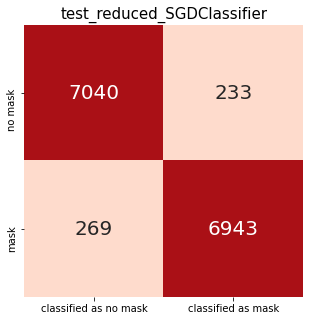

>... Saving figure Confusion_Matrix_test_reduced_SGDClassifier_24
>... Eval metrics pickle file successfully loaded for test_reduced_RandomForestClassifier and pixel resolution 24
>... Displaying confusion matrix for test_reduced_RandomForestClassifier and pixel resolution 24


<Figure size 432x288 with 0 Axes>

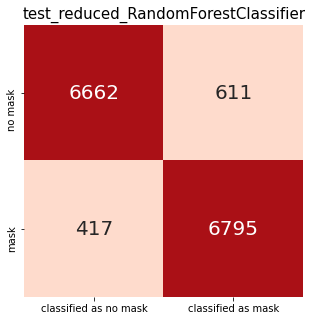

>... Saving figure Confusion_Matrix_test_reduced_RandomForestClassifier_24


<Figure size 432x288 with 0 Axes>

In [39]:
###### Confusion Matrix ######
# List all files of eval dictionary folder
filenames_eval_dics = []
for root, dirs, files in os.walk(SAVE_PATH_EVAL):
    for name in files:
        filenames_eval_dics.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_eval_dics_pix = []
for i in range(len(filenames_eval_dics)):
    if str(pix_res) in filenames_eval_dics[i] and "_test_reduced_" in filenames_eval_dics[i]:
        filenames_eval_dics_pix.append(filenames_eval_dics[i])

# Display confusion matrix
for i in range(len(filenames_eval_dics_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

    # Load pikle-file and display pandas data frame filtered to error types
    dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
    print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    # Extract confusion matrix data into data frame
    cm_data = dict_eval_metrics["Confusion matrix"]
    plot_matrix = pd.DataFrame(cm_data, columns = ["classified as no mask", "classified as mask"],
                        index = ["no mask", "mask"])

    # Actual plot with seaborn and saving figure with different file names depending on switch
    print(">... Displaying confusion matrix for {} and pixel resolution {}".format(classifier_name, pix_res))
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        plt.show()
        save_fig("99_CM_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
    elif "full" in filenames_eval_dics_pix[i]:
        plt.figure(figsize = (5,5))
        colormap = sns.color_palette("Reds")
        ax = plt.axes()
        sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
        ax.set_title(classifier_name, fontsize= 15)
        plt.show()
        save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

In [40]:
pix_res=24
###### Eval Metrics ######
# List all files of eval dictionary folder
filenames_eval_dics = []
for root, dirs, files in os.walk(SAVE_PATH_EVAL):
    for name in files:
        filenames_eval_dics.append(os.path.join(root, name))

# Select all filenames corresponding to pixel size
filenames_eval_dics_pix = []
for i in range(len(filenames_eval_dics)):
    if str(pix_res) in filenames_eval_dics[i] and "_test_reduced_" in filenames_eval_dics[i]:
        filenames_eval_dics_pix.append(filenames_eval_dics[i])

eval_metrics = {}
for i in range(len(filenames_eval_dics_pix)):
    # Extract classifier name from filename
    if "dummy_toy" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    elif "full" in filenames_eval_dics_pix[i]:
        # Find pixel resolution in filenames
        search_term = "evaluation_scores_"
        pos_start = filenames_eval_dics_pix[i].find(search_term)
        pos_end = filenames_eval_dics_pix[i].find("_full_")
        help_length = len(search_term) #To add on starting posting
        classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
    else:
        raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")


    # Load pikle-file and display pandas data frame filtered to error types
    dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
    print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
    # Extract eval metrics into data frame
    precision_score = dict_eval_metrics["Precision Score"]
    recall_score = dict_eval_metrics["Recall Score"]
    accuracy_score = dict_eval_metrics["Accuracy Score"]
    eval_run_time = dict_eval_metrics["Prediction time in seconds"]

    #Storing in eval_metrics library
    eval_metrics[classifier_name] = [precision_score,
                                     recall_score,
                                     accuracy_score,
                                     eval_run_time]

# Output table of metrics
print(">... Display eval metrics table for pixel resolution {}\n\n".format(pix_res))
index = ["precision score", "recall score", "accuracy_score", "prediction time in seconds"]
table_eval_metrics = pd.DataFrame(eval_metrics, index)
table_eval_metrics

>... Eval metrics pickle file successfully loaded for test_reduced_SGDClassifier and pixel resolution 24
>... Eval metrics pickle file successfully loaded for test_reduced_RandomForestClassifier and pixel resolution 24
>... Display eval metrics table for pixel resolution 24




,test_reduced_SGDClassifier,test_reduced_RandomForestClassifier
precision score,0.968,0.917
recall score,0.963,0.942
accuracy_score,0.965,0.929
prediction time in seconds,0.003,1.069


<br>
<br>
<br>
<br>
<br>
<br>

### Final output table

In [41]:
# Loading all necessary files
dict_RF_Baseline_evals = pickle.load(open("03_output/01_eval_scores/evaluation_scores_test_baseline_RandomForestClassifier_full_24.pkl","rb"))
dict_RF_Baseline_time = pickle.load(open("03_output/03_run_time_scores/run_time_test_baseline_full_RandomForestClassifier_24.pkl","rb"))
dict_RF_Accuracy_Tuned_evals = pickle.load(open("03_output/04_eval_scores_hypertuning/evaluation_scores_test_RandomForestClassifier_full_24.pkl","rb"))
dict_RF_Accuracy_Tuned_time = pickle.load(open("03_output/06_run_time_scores_hyptertuning/run_time_test_full_RandomForestClassifier_24.pkl","rb"))
dict_RF_Speed_Tuned_evals = pickle.load(open("03_output/04_eval_scores_hypertuning/evaluation_scores_test_reduced_RandomForestClassifier_full_24.pkl","rb"))
dict_RF_Speed_Tuned_time = pickle.load(open("03_output/06_run_time_scores_hyptertuning/run_time_test_full_reduced_RandomForestClassifier_24.pkl","rb"))

dict_SGD_Baseline_evals = pickle.load(open("03_output/01_eval_scores/evaluation_scores_test_baseline_SGDClassifier_full_24.pkl","rb"))
dict_SGD_Baseline_time = pickle.load(open("03_output/03_run_time_scores/run_time_test_baseline_full_SGDClassifier_24.pkl","rb"))
dict_SGD_Accuracy_Tuned_evals = pickle.load(open("03_output/04_eval_scores_hypertuning/evaluation_scores_test_SGDClassifier_full_24.pkl","rb"))
dict_SGD_Accuracy_Tuned_time = pickle.load(open("03_output/06_run_time_scores_hyptertuning/run_time_test_full_SGDClassifier_24.pkl","rb"))
dict_SGD_Speed_Tuned_evals = pickle.load(open("03_output/04_eval_scores_hypertuning/evaluation_scores_test_reduced_SGDClassifier_full_24.pkl","rb"))
dict_SGD_Speed_Tuned_time = pickle.load(open("03_output/06_run_time_scores_hyptertuning/run_time_test_full_reduced_SGDClassifier_24.pkl","rb"))

In [42]:
# Define lists to loop through
dict_list_evals = [dict_RF_Baseline_evals, dict_RF_Accuracy_Tuned_evals, dict_RF_Speed_Tuned_evals,
                  dict_SGD_Baseline_evals, dict_SGD_Accuracy_Tuned_evals, dict_SGD_Speed_Tuned_evals]
dict_list_times = [dict_RF_Baseline_time, dict_RF_Accuracy_Tuned_time, dict_RF_Speed_Tuned_time,
                  dict_SGD_Baseline_time, dict_SGD_Accuracy_Tuned_time, dict_SGD_Speed_Tuned_time]
key_list = ["Accuracy Score", "Precision Score", "Recall Score", "Prediction time in seconds", "24"]

#Initialize combined dictionary
dict_total = {}

# Loop through list to store metrics
for key in key_list:
    help_list = []
    if key == "24":
        for dict_itr in dict_list_times:
            help_list.append(dict_itr[key])
        dict_total["Training time in seconds"] = help_list
    else:
        for dict_itr in dict_list_evals:
            help_list.append(dict_itr[key])
        dict_total[key] = help_list

# Set output table
row_headers = ["RF: Baseline", "RF: Tuned Accuracy", "RF: Tuned Speed",
              "SGD: Baseline", "SGD: Tuned Accuracy", "SGD: Tuned Speed"]
final_table = pd.DataFrame(dict_total, row_headers)
final_table

,Accuracy Score,Precision Score,Recall Score,Prediction time in seconds,Training time in seconds
RF: Baseline,0.993,0.994,0.991,0.532,341.100
RF: Tuned Accuracy,0.993,0.994,0.993,1.157,1360.784
RF: Tuned Speed,0.929,0.917,0.942,1.069,724.284
SGD: Baseline,0.821,0.999,0.640,0.020,66.672
SGD: Tuned Accuracy,0.976,0.966,0.987,0.018,32.567
SGD: Tuned Speed,0.965,0.968,0.963,0.003,5.106
